In [3]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers.core import Lambda, Flatten
from keras.layers import Input, Dot
from keras.preprocessing import image

from sklearn.metrics import roc_curve, auc
from scipy import spatial
import scipy.stats as stats
import operator
import tensorflow as tf
import soundfile as sf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import IPython.display
import numpy as np
import PIL.Image
from IPython.display import display, Audio
import time as time
import scipy
import pickle
import os
import pandas as pd
from scipy.io import wavfile
import scipy.ndimage
from scipy import spatial
from scipy.signal import butter, lfilter
import IPython.display as ipd
import csv 

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import copy
import decimal
import librosa
import logging
import math
import random
import numpy as np

import warnings
warnings.filterwarnings('ignore')

random.seed(9001)
from matplotlib2tikz import save as tikz_save

Using TensorFlow backend.


# Creating Deep Master Voices for Dictionary Attacks on Speaker Authentication Systems

- RQ1: Is it possible to find one or more existing “Master Voices” that match with a large number of voices originating from different users?
- RQ2: Is it possible to generate such “Master Voices” synthetically and, if so, how they can be generated starting from a known population of voices? 


## Section 1: Voice Parameters Definition

In [4]:
params = {'max_sec':10,'bucket_step':1,'frame_step':0.01,'sample_rate':16000,'preemphasis_alpha':0.97,'frame_len':0.025,'num_fft':512}

In [5]:
def build_buckets(max_sec, step_sec, frame_step):
    buckets = {}
    frames_per_sec = int(1/frame_step)
    end_frame = int(max_sec*frames_per_sec)
    step_frame = int(step_sec*frames_per_sec)
    for i in range(0, end_frame+1, step_frame):
        s = i
        s = np.floor((s-7+2)/2) + 1  # conv1
        s = np.floor((s-3)/2) + 1  # mpool1
        s = np.floor((s-5+2)/2) + 1  # conv2
        s = np.floor((s-3)/2) + 1  # mpool2
        s = np.floor((s-3+2)/1) + 1  # conv3
        s = np.floor((s-3+2)/1) + 1  # conv4
        s = np.floor((s-3+2)/1) + 1  # conv5
        s = np.floor((s-3)/2) + 1  # mpool5
        s = np.floor((s-1)/1) + 1  # fc6
        if s > 0:
            buckets[i] = int(s)
    return buckets

In [6]:
buckets = build_buckets(params['max_sec'], params['bucket_step'], params['frame_step'])

In [7]:
def denormalize_frames(m, means, stds, epsilon=1e-12):
    return np.array([z * max(stds[i],epsilon) + means[i] for i, z in enumerate(m)])

def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

def rolling_window(a, window, step=1):
    # http://ellisvalentiner.com/post/2017-03-21-np-strides-trick
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]

def framesig(sig, frame_len, frame_step, winfunc=lambda x: np.ones((x,)), stride_trick=True):
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step)) # LV

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(
            np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = np.array(indices, dtype=np.int32)
        frames = padsignal[indices]
        win = np.tile(winfunc(frame_len), (numframes, 1))

    return frames * win

def deframesig(frames, siglen, frame_len, frame_step, winfunc=lambda x: np.ones((x,))):
    frame_len = round_half_up(frame_len)
    frame_step = round_half_up(frame_step)
    numframes = np.shape(frames)[0]
    assert np.shape(frames)[1] == frame_len, '"frames" matrix is wrong size, 2nd dim is not equal to frame_len'

    indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(
        np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
    indices = np.array(indices, dtype=np.int32)
    padlen = (numframes - 1) * frame_step + frame_len

    if siglen <= 0: siglen = padlen

    rec_signal = np.zeros((padlen,))
    window_correction = np.zeros((padlen,))
    win = winfunc(frame_len)

    for i in range(0, numframes):
        window_correction[indices[i, :]] = window_correction[
                                               indices[i, :]] + win + 1e-15  # add a little bit so it is never zero
        rec_signal[indices[i, :]] = rec_signal[indices[i, :]] + frames[i, :]

    rec_signal = rec_signal / window_correction
    return rec_signal[0:siglen]

def magspec(frames, NFFT):
    if np.shape(frames)[1] > NFFT:
        logging.warn(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            np.shape(frames)[1], NFFT)
    complex_spec = np.fft.rfft(frames, NFFT)
    return np.absolute(complex_spec)

def powspec(frames, NFFT):
    return 1.0 / NFFT * np.square(magspec(frames, NFFT))

def logpowspec(frames, NFFT, norm=1):
    ps = powspec(frames, NFFT);
    ps[ps <= 1e-30] = 1e-30
    lps = 10 * np.log10(ps)
    if norm:
        return lps - np.max(lps)
    else:
        return lps

def preemphasis(signal, coeff=0.95):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def load_wav(filename, sample_rate):
    audio, sr = librosa.load(filename, sr=sample_rate, mono=True)
    audio = audio.flatten()
    return audio

def normalize_frames(m,epsilon=1e-12):
    frames = []
    means = []
    stds = []
    for v in m:
        means.append(np.mean(v))
        stds.append(np.std(v))
        frames.append((v - np.mean(v)) / max(np.std(v), epsilon)) 
    return np.array(frames), np.array(means), np.array(stds)

def remove_dc_and_dither(sin, sample_rate):
    if sample_rate == 16e3:
        alpha = 0.99
    elif sample_rate == 8e3:
        alpha = 0.999
    else:
        print("Sample rate must be 16kHz or 8kHz only")
        exit(1)
    sin = lfilter([1,-1], [1,-alpha], sin)
    dither = np.random.random_sample(len(sin)) + np.random.random_sample(len(sin)) - 1
    spow = np.std(dither)
    sout = sin + 1e-6 * spow * dither
    return sout

def get_fft_spectrum(filename, buckets, params):
    signal, rate = librosa.load(filename, sr=params['sample_rate'], mono=True)
    frames = framesig(signal, frame_len=params['frame_len'] * params['sample_rate'], frame_step=params['frame_step']*params['sample_rate'], winfunc=np.hamming)
    fft = abs(np.fft.fft(frames,n=params['num_fft']))
    fft_norm, fft_means, fft_stds = normalize_frames(fft.T)
    return fft_norm, fft_means, fft_stds

In [8]:
def save_obj(obj,name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Section 2: VGGVox Voice Verification System

In [9]:
model = load_model('vggvox.h5')

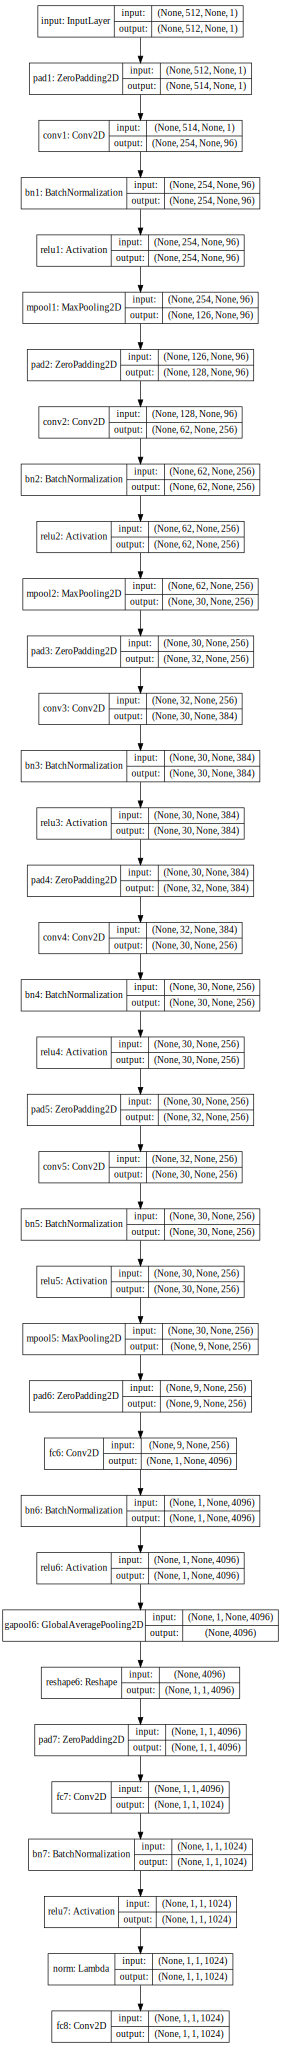

In [10]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

## Section 3: VoxCeleb2 Dataset

In [11]:
vox_meta = pd.read_csv('vox2_meta.csv', header=None, names=['vid', 'vggid', 'gender', 'set'])

In [12]:
train_source = '../data/voxceleb2/dev'

#### The distribution of utterances per person 

In [15]:
users_samples = {}
for index_user_folder, user_folder in enumerate(os.listdir(train_source)):
    gender = vox_meta.loc[vox_meta.vid == user_folder, 'gender'].values[0]
    print('\rLoading training user', index_user_folder, '/', len(os.listdir(train_source)), end='')
    user_samples = 0
    user_folder_path = os.path.join(train_source, user_folder)
    for index_video_folder, video_folder in enumerate(os.listdir(user_folder_path)):
        video_folder_path = os.path.join(train_source, user_folder, video_folder)
        for index_audio_folder, audio_file in enumerate(os.listdir(video_folder_path)):
            user_samples += 1
    users_samples[user_folder] = user_samples

Loading training user 5993 / 5994

In [18]:
save_obj(users_samples, '../data/backup/vox2_user_samples.pkl')

In [13]:
users_samples = load_obj('../data/backup/vox2_user_samples.pkl')

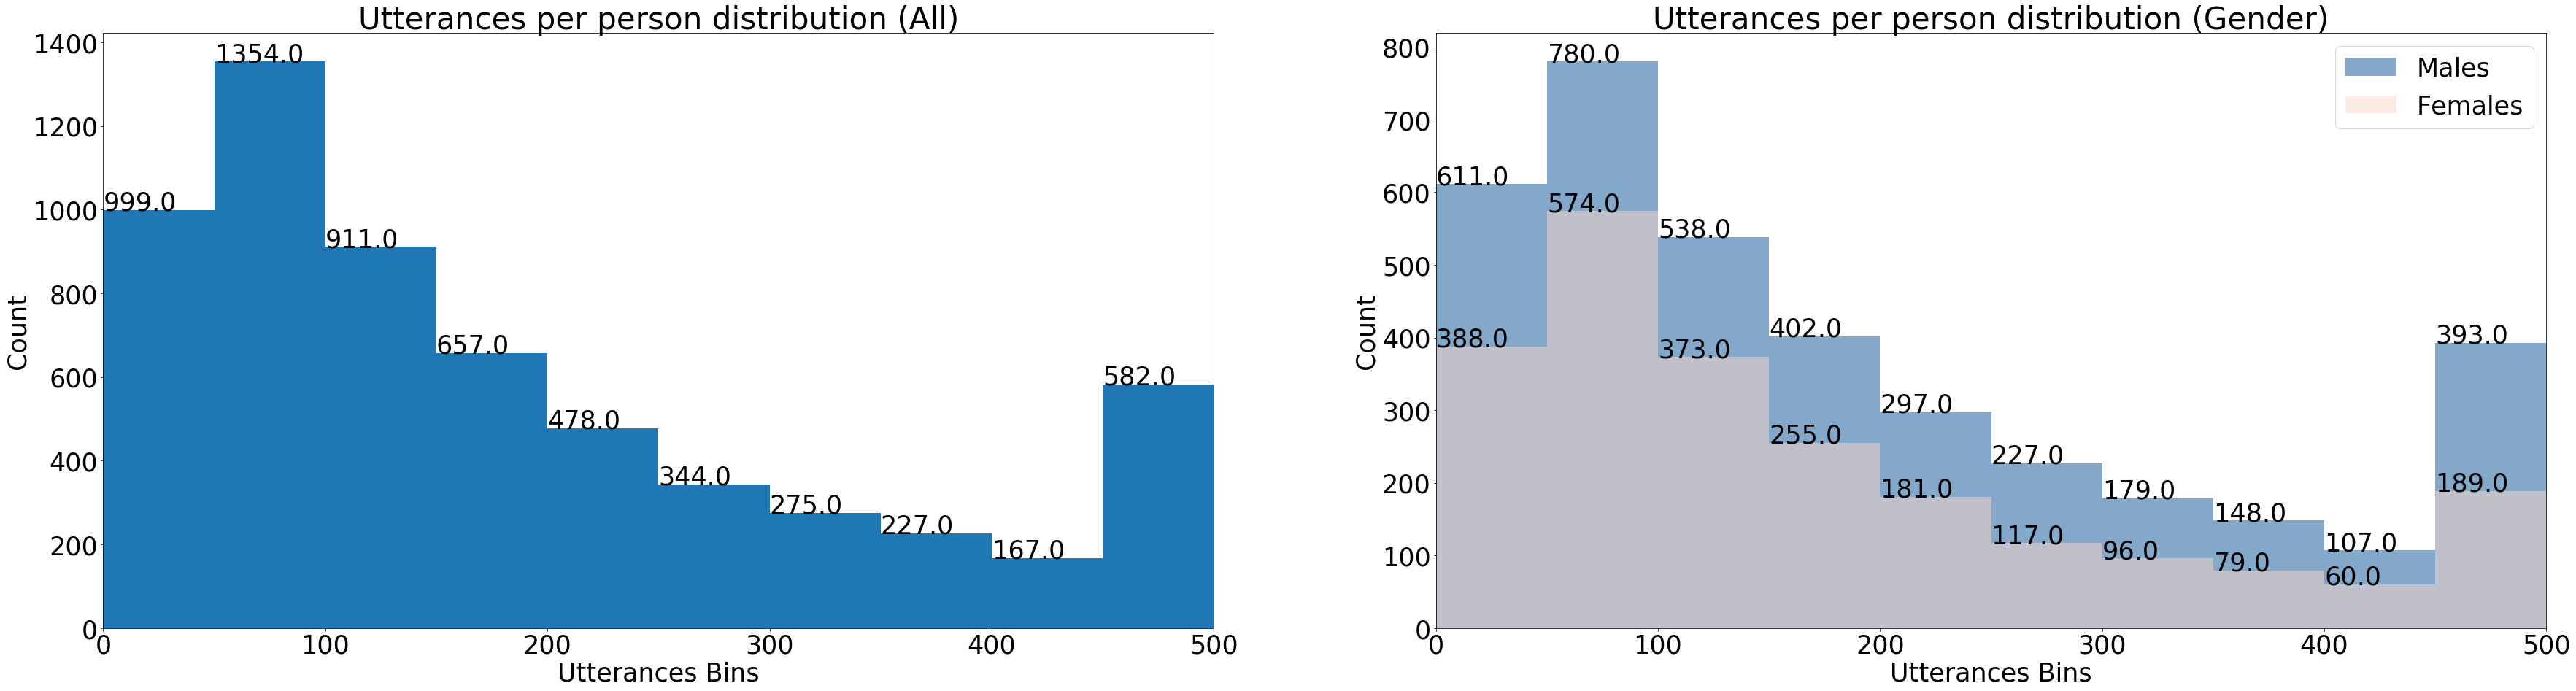

In [20]:
plt.rcParams.update({'font.size': 35})
plt.figure(figsize=(60, 15))

plt.subplot(121)
plt.title('Utterances per person distribution (All)')
arr = plt.hist(users_samples.values(), bins=range(0,550,50))
for i in range(len(arr[1]) - 1):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.xlim([0, 500])
plt.xlabel('Utterances Bins')
plt.ylabel('Count')

plt.subplot(122)
plt.title('Utterances per person distribution (Gender)')
males_samples = [value for key, value in users_samples.items() if vox_meta.loc[vox_meta.vid == key, 'gender'].values[0] == 'm']
arr = plt.hist(males_samples, bins=range(0,550,50), fc=(0.04, 0.32, 0.58, 0.5), label='Males')
for i in range(len(arr[1]) - 1):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
females_samples = [value for key, value in users_samples.items() if vox_meta.loc[vox_meta.vid == key, 'gender'].values[0] == 'f']
arr = plt.hist(females_samples, bins=range(0,550,50), fc=(1.00, 0.85, 0.80, 0.5), label='Females')
for i in range(len(arr[1]) - 1):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
    
plt.xlim([0, 500])
plt.xlabel('Utterances Bins')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.show()

#### Creation of training and testing datasets for master voices

In [14]:
n_female_users = 500 # Number of females in the training set
n_male_users = 500 # Number of males in the training set
min_samples_per_user = 50 # Minimum number of samples that a user must have in order to become part of the training dataset
max_samples_per_user = 100  # Minimum number of samples that a user must have in order to become part of the training dataset
fixed_samples_per_user = 50 # Maximum number of samples that a user must have in order to become part of the training dataset
n_train_users = n_female_users + n_male_users

In [ ]:
female_users = []
for index_user_folder, user_folder in enumerate(os.listdir(train_source)):
    gender = vox_meta.loc[vox_meta.vid == user_folder, 'gender'].values[0]
    if gender == 'f':
        print('\rLoading training female user', user_folder, end='')
        user_samples = 0
        user_folder_path = os.path.join(train_source, user_folder)
        for index_video_folder, video_folder in enumerate(os.listdir(user_folder_path)):
            video_folder_path = os.path.join(train_source, user_folder, video_folder)
            for index_audio_folder, audio_file in enumerate(os.listdir(video_folder_path)):
                user_samples += 1
        if user_samples >= min_samples_per_user and user_samples < max_samples_per_user:
            female_users.append(user_folder)
print('\nRetrieved', len(female_users), 'with at least', min_samples_per_user, 'utterances')
female_users = random.sample(female_users, n_female_users)
print('Selected', len(female_users), 'with', fixed_samples_per_user, 'utterances')

In [ ]:
male_users = []
for index_user_folder, user_folder in enumerate(os.listdir(train_source)):
    gender = vox_meta.loc[vox_meta.vid == user_folder, 'gender'].values[0]
    if gender == 'm':
        print('\rLoading training male user', user_folder, end='')
        user_samples = 0
        user_folder_path = os.path.join(train_source, user_folder)
        for index_video_folder, video_folder in enumerate(os.listdir(user_folder_path)):
            video_folder_path = os.path.join(train_source, user_folder, video_folder)
            for index_audio_folder, audio_file in enumerate(os.listdir(video_folder_path)):
                user_samples += 1
        if user_samples >= min_samples_per_user and user_samples < max_samples_per_user:
            male_users.append(user_folder)
print('\nRetrieved', len(male_users), 'with at least', min_samples_per_user, 'utterances')
male_users = random.sample(male_users, n_male_users)
print('Selected', len(male_users), 'with', fixed_samples_per_user, 'utterances')

In [ ]:
train_users = female_users + male_users

In [ ]:
train_paths = []
train_labels = []
counter_males = 0
counter_females = 0
for index_user_folder, user_folder in enumerate(os.listdir(train_source)):
    if user_folder in train_users:
        print('\rLoading training user', user_folder, end='')
        gender = vox_meta.loc[vox_meta.vid == user_folder, 'gender'].values[0]
        counter_males += 1 if gender == 'm' else 0
        counter_females += 1 if gender == 'f' else 0
        user_folder_path = os.path.join(train_source, user_folder)
        user_paths = []
        user_labels = []
        for index_video_folder, video_folder in enumerate(os.listdir(user_folder_path)):
            video_folder_path = os.path.join(train_source, user_folder, video_folder)
            for index_audio_folder, audio_file in enumerate(os.listdir(video_folder_path)):
                user_paths.append(os.path.join(train_source, user_folder, video_folder, audio_file))
                user_labels.append(index_user_folder)
        indexes = random.sample(range(len(user_paths)), fixed_samples_per_user)
        train_paths += [user_paths[i] for i in indexes]
        train_labels += [user_labels[i] for i in indexes]
print('\nTraining samples', len(train_labels), 'from users', len(np.unique(train_labels)))
print('Males samples', counter_males)
print('Females samples', counter_females)

In [ ]:
save_obj(train_paths, '../data/backup/train_vox2_paths_1000_users')
save_obj(train_labels, '../data/backup/train_vox2_labels_1000_users')

In [15]:
train_paths = load_obj('../data/backup/train_vox2_paths_1000_users')
train_labels = load_obj('../data/backup/train_vox2_labels_1000_users')

In [16]:
ordered_labels = np.unique(train_labels)
males = []
females = []
for p_index, path in enumerate(train_paths):
    if (p_index+1) % 100 == 0:
        print('\rStep', p_index+1, '/', len(train_paths), end='')
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    if gender == 'm':
        males.append(p_index)
    else:
        females.append(p_index)

Step 50000 / 50000

In [17]:
test_paths = load_obj('../data/backup/test_vox2_paths_1000_users')
test_labels = load_obj('../data/backup/test_vox2_labels_1000_users')

In [18]:
test_ordered_labels = np.unique(test_labels)
test_males = []
test_females = []
for p_index, path in enumerate(test_paths):
    if (p_index+1) % 100 == 0:
        print('\rStep', p_index+1, '/', len(test_paths), end='')
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    if gender == 'm':
        test_males.append(p_index)
    else:
        test_females.append(p_index)

Step 100000 / 100000

#### Generation of the train and test embeddings

In [ ]:
print('Extracting embeddings from', len(train_paths), 'utterances')
step = 0 
embs = np.zeros((len(train_paths), 1024))

while step < len(train_paths):
    sp, _, _ = get_fft_spectrum(train_paths[step], buckets, params)
    embs[step,] = contr_model.predict(sp.reshape(1, *sp.shape, 1))[0]
    print('\rStep ' + str(step) + '/' + str(len(train_paths)), train_paths[step], end='')
    step += 1
    
np.save('../data/backup/train_vox2_embs_1000_users.npy', embs)

In [19]:
embs = np.load('../data/backup/train_vox2_embs_1000_users_invsp.npy')
test_embs = np.load('../data/backup/test_vox2_embs_1000_users_invsp.npy')

In [17]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 3.688s...
[t-SNE] Computed neighbors for 50000 samples in 3658.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


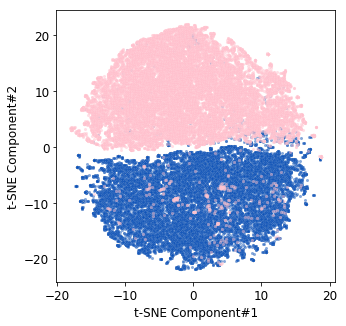

In [462]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[males,0], tsne_results[males,1], s=np.pi*3, c=(0.05,0.32,0.72), linewidth=0.1, edgecolor='white', alpha=0.5)
plt.scatter(tsne_results[females,0], tsne_results[females,1], s=np.pi*3, c=(1.0,0.75,0.80), linewidth=0.1, edgecolor='white', alpha=0.5)
plt.xlabel('t-SNE Component#1')
plt.ylabel('t-SNE Component#2')
#tikz_save("exp_gender_vecs.tex")
plt.savefig("exp_gender_vecs.pdf", bbox_inches='tight')
tikz_save("exp_gender_vecs.tex")
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


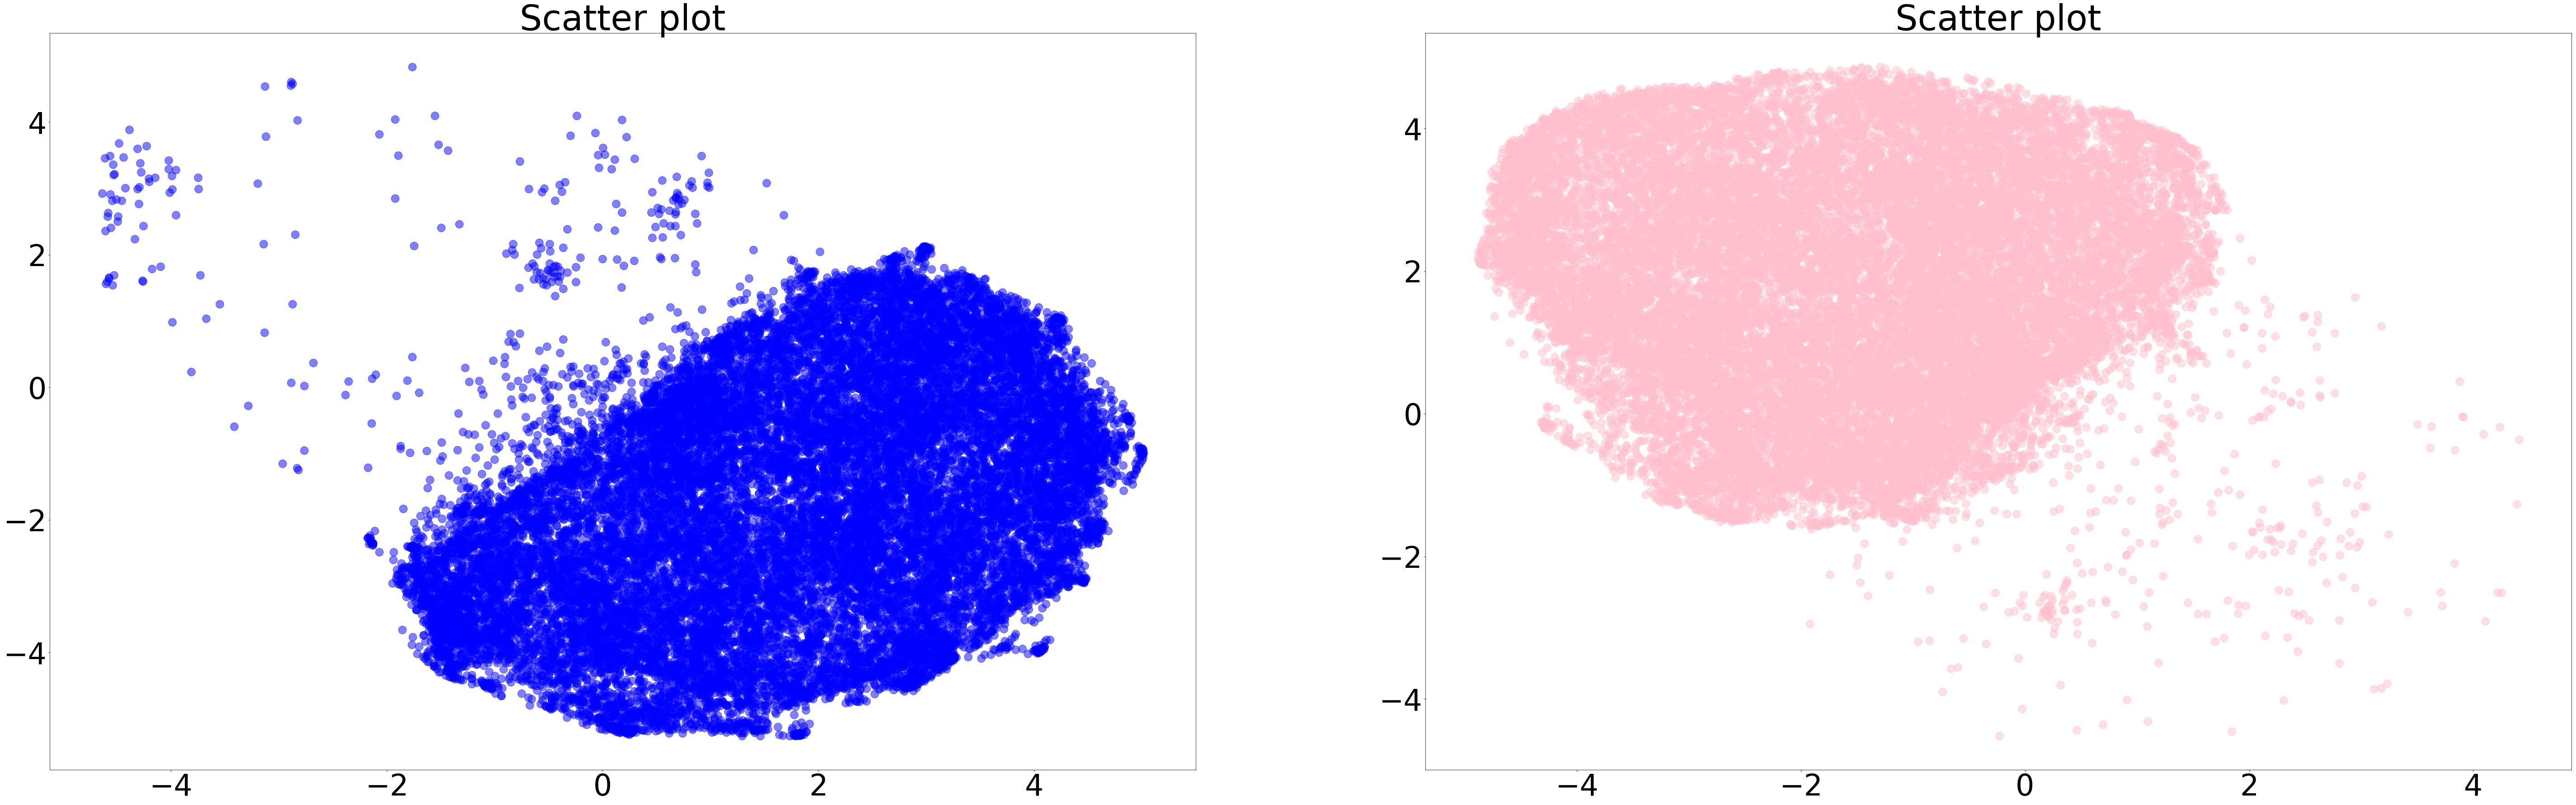

In [431]:
plt.rcParams.update({'font.size': 65})
plt.figure(figsize=(100, 30))

plt.subplot(121)
plt.scatter(tsne_results[males,0], tsne_results[males,1], s=np.pi*100, c=(0.0,0.0,1.0), alpha=0.5, marker='x')
plt.title('Scatter plot')

plt.subplot(122)
plt.scatter(tsne_results[females,0], tsne_results[females,1], s=np.pi*100, c=(1.0,0.75,0.80), alpha=0.5, marker='+')
plt.title('Scatter plot')

plt.show()

#### Computation of the similarity matrix for training utterances

In [ ]:
for k in range(1):
    similarities = np.ones((10000, len(train_paths))) 
    
    for i in range(10000):
        print('\r', k*10000+i, 'Step ' + str(i) + '/' + str(10000), train_paths[k*10000+i], end='')
        for j in range(len(train_paths)):
            similarity = 1 - spatial.distance.cosine(embs[k*10000+i], embs[j])
            similarities[i,j] = similarity
            
    np.save('../data/backup/train_vox2_sim_1000_users_' + str(k) + '.npy', similarities)

In [20]:
similarities = np.load('../data/backup/train_vox2_sim_1000_users_1.npy')
for f_index in [2, 3, 4, 5]:
    new_similarities = np.load('../data/backup/train_vox2_sim_1000_users_' + str(f_index) + '.npy')
    similarities = np.concatenate((similarities, new_similarities), axis=0)

## Section 4: Are there “Master Voices” that match with a large number of voices originating from different users?

#### Computation of the average genuine and imposter scores 

In [53]:
avg_pos_scores = []
avg_neg_scores = [] 
only_male_avg_pos_scores = []
only_female_avg_pos_scores = []
only_male_avg_neg_scores = [] 
only_female_avg_neg_scores = [] 
for u_index, user_label in enumerate(ordered_labels):
    print('\rIndex', u_index, 'User Label', user_label, end='')
    sample_path = train_paths[u_index*50]
    gender = vox_meta.loc[vox_meta.vid == sample_path.split('/')[4], 'gender'].values[0]
    user_rows = similarities[(u_index*50):(u_index*50+50),:]
    avg_pos_scores.append(np.mean(user_rows[:,(u_index*50):(u_index*50+50)]))
    avg_neg_scores.append(np.mean(np.delete(user_rows, range(u_index*50, u_index*50+50), 1)))
    if gender == 'm':
        only_male_avg_pos_scores.append(np.mean(user_rows[:,(u_index*50):(u_index*50+50)]))
        only_male_avg_neg_scores.append(np.mean(np.delete(user_rows, list(range(u_index*50, u_index*50+50)) + females, 1)))
    else:
        only_female_avg_pos_scores.append(np.mean(user_rows[:,(u_index*50):(u_index*50+50)]))
        only_female_avg_neg_scores.append(np.mean(np.delete(user_rows, list(range(u_index*50, u_index*50+50)) + males, 1)))

Index 999 User Label 5985

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

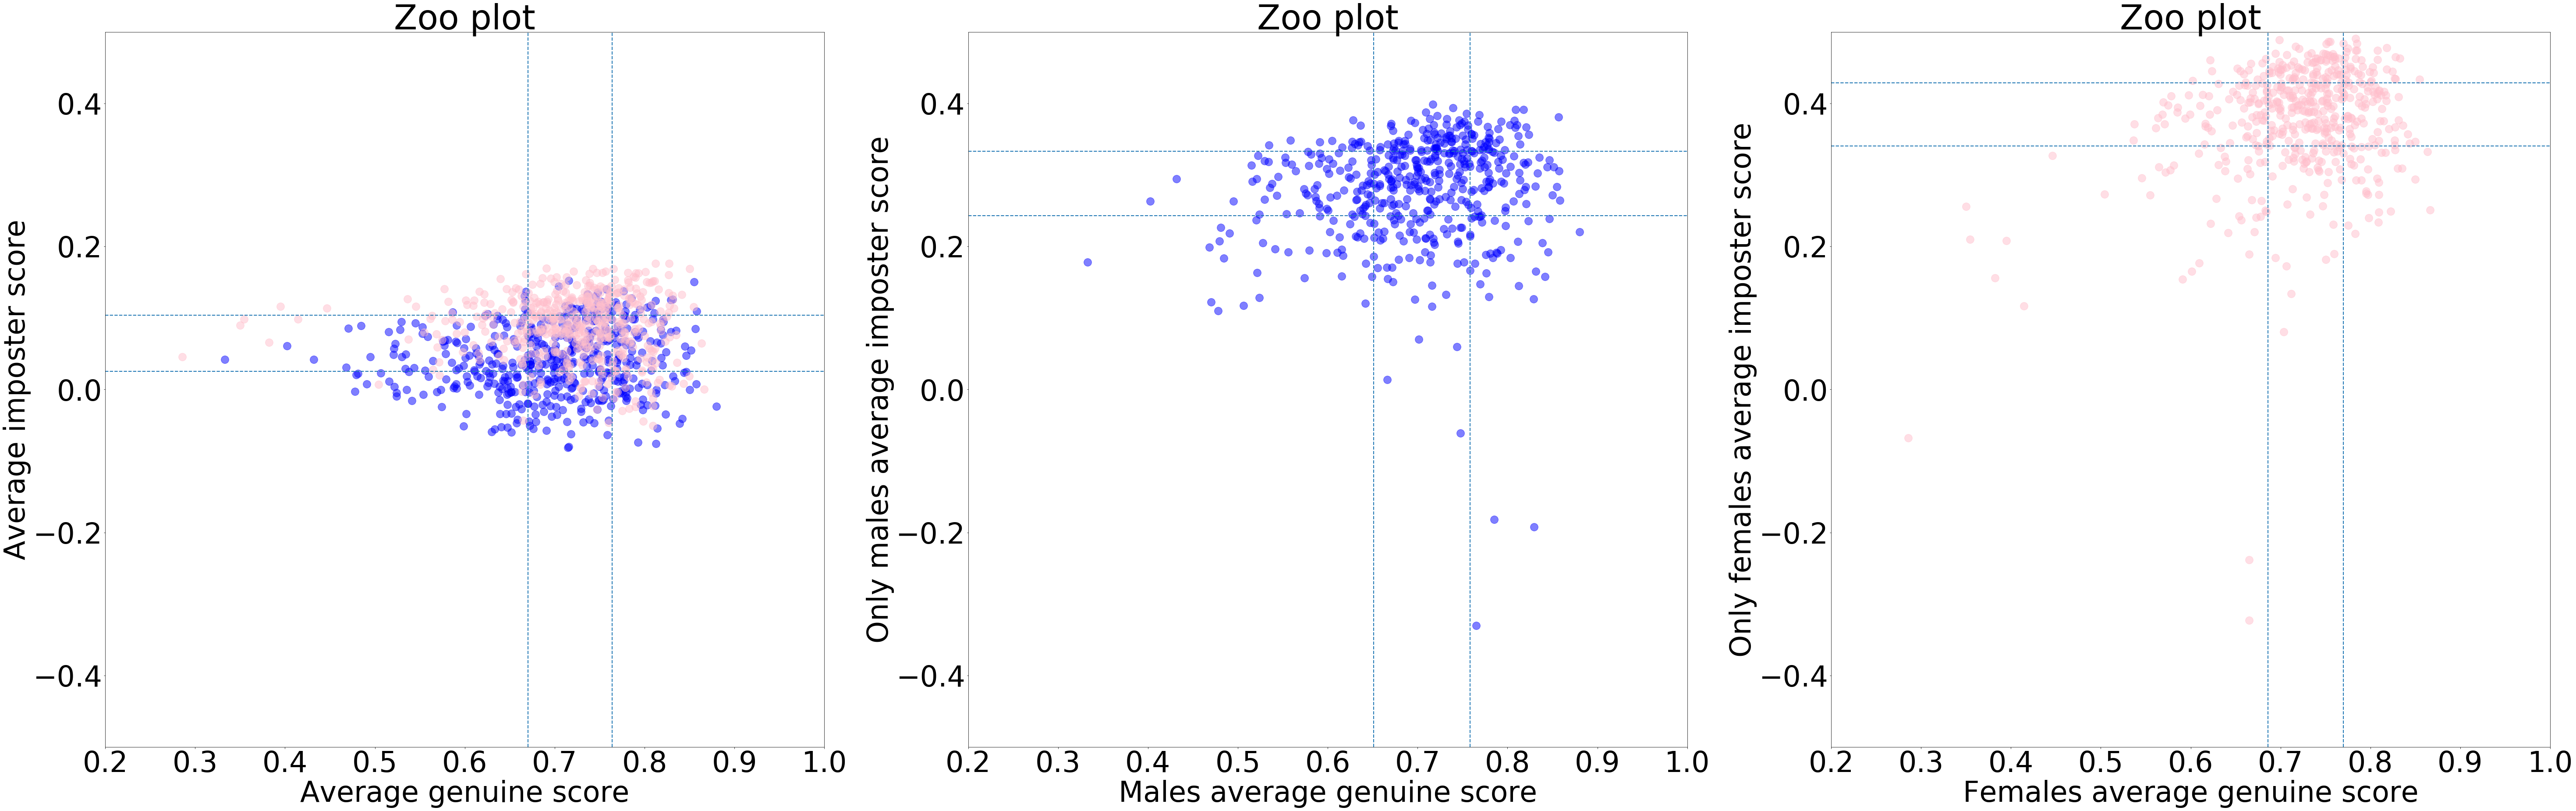

In [54]:
plt.rcParams.update({'font.size': 65})
plt.figure(figsize=(100, 30))

plt.subplot(131)
male_avg_pos_scores = []
male_avg_neg_scores = []
female_avg_pos_scores = []
female_avg_neg_scores = []
for u_index, user_label in enumerate(ordered_labels):
    sample_path = train_paths[u_index*50]
    gender = vox_meta.loc[vox_meta.vid == sample_path.split('/')[4], 'gender'].values[0]
    if gender == 'm':
        male_avg_pos_scores.append(avg_pos_scores[u_index])
        male_avg_neg_scores.append(avg_neg_scores[u_index])
    else:
        female_avg_pos_scores.append(avg_pos_scores[u_index])
        female_avg_neg_scores.append(avg_neg_scores[u_index])
plt.scatter(male_avg_pos_scores, male_avg_neg_scores, s=np.pi*100, c=(0.0,0.0,1.0), alpha=0.5)
plt.scatter(female_avg_pos_scores, female_avg_neg_scores, s=np.pi*100, c=(1.0,0.75,0.80), alpha=0.5)
plt.axvline(x=np.percentile(avg_pos_scores, 25), linestyle='--', lw=2)
plt.axvline(x=np.percentile(avg_pos_scores, 75), linestyle='--', lw=2)
plt.axhline(y=np.percentile(avg_neg_scores, 25), linestyle='--', lw=2)
plt.axhline(y=np.percentile(avg_neg_scores, 75), linestyle='--', lw=2)
plt.xlim([0.2, 1.0])
plt.ylim([-0.5, 0.5])
plt.title('Zoo plot')
plt.xlabel('Average genuine score')
plt.ylabel('Average imposter score')

plt.subplot(132)
plt.scatter(only_male_avg_pos_scores, only_male_avg_neg_scores, s=np.pi*100, c=(0.0,0.0,1.0), alpha=0.5)
plt.axvline(x=np.percentile(only_male_avg_pos_scores, 25), linestyle='--', lw=2)
plt.axvline(x=np.percentile(only_male_avg_pos_scores, 75), linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_male_avg_neg_scores, 25), linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_male_avg_neg_scores, 75), linestyle='--', lw=2)
plt.xlim([0.2, 1.0])
plt.ylim([-0.5, 0.5])
plt.title('Zoo plot')
plt.xlabel('Males average genuine score')
plt.ylabel('Only males average imposter score')

plt.subplot(133)
plt.scatter(only_female_avg_pos_scores, only_female_avg_neg_scores, s=np.pi*100, c=(1.0,0.75,0.80), alpha=0.5)
plt.axvline(x=np.percentile(only_female_avg_pos_scores, 25), linestyle='--', lw=2)
plt.axvline(x=np.percentile(only_female_avg_pos_scores, 75), linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_female_avg_neg_scores, 25), linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_female_avg_neg_scores, 75), linestyle='--', lw=2)
plt.xlim([0.2, 1.0])
plt.ylim([-0.5, 0.5])
plt.title('Zoo plot')
plt.xlabel('Females average genuine score')
plt.ylabel('Only females average imposter score')

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


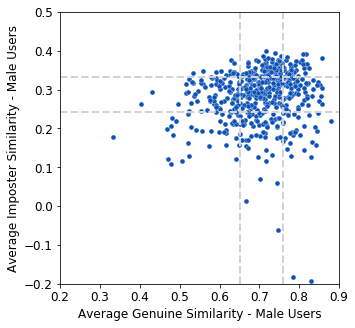

In [463]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
plt.scatter(only_male_avg_pos_scores, only_male_avg_neg_scores, s=np.pi*8, c=(0.05,0.32,0.72), linewidth=0.3, edgecolor='white', alpha=1)
plt.axvline(x=np.percentile(only_male_avg_pos_scores, 25), color='lightgrey', linestyle='--', lw=2)
plt.axvline(x=np.percentile(only_male_avg_pos_scores, 75), color='lightgrey', linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_male_avg_neg_scores, 25), color='lightgrey', linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_male_avg_neg_scores, 75), color='lightgrey', linestyle='--', lw=2)
plt.xlim([0.2, 0.9])
plt.ylim([-0.2, 0.5])
plt.xlabel('Average Genuine Similarity - Male Users')
plt.ylabel('Average Imposter Similarity - Male Users')
plt.savefig("exp_manag_male.pdf", bbox_inches='tight')
tikz_save("exp_manag_male.tex")
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


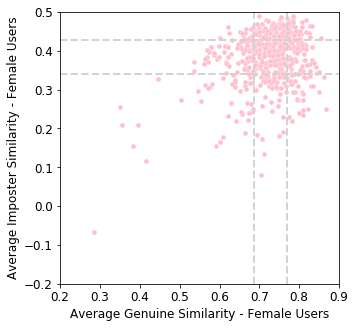

In [464]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
plt.scatter(only_female_avg_pos_scores, only_female_avg_neg_scores, s=np.pi*8, c=(1.0,0.75,0.80), linewidth=0.3, edgecolor='white', alpha=1)
plt.axvline(x=np.percentile(only_female_avg_pos_scores, 25), color='lightgrey', linestyle='--', lw=2)
plt.axvline(x=np.percentile(only_female_avg_pos_scores, 75), color='lightgrey', linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_female_avg_neg_scores, 25), color='lightgrey', linestyle='--', lw=2)
plt.axhline(y=np.percentile(only_female_avg_neg_scores, 75), color='lightgrey', linestyle='--', lw=2)
plt.xlim([0.2, 0.9])
plt.ylim([-0.2, 0.5])
plt.xlabel('Average Genuine Similarity - Female Users')
plt.ylabel('Average Imposter Similarity - Female Users')
plt.savefig("exp_manag_female.pdf", bbox_inches='tight')
tikz_save("exp_manag_female.tex")
plt.show()

#### Calculating the thresholds for verification

In [149]:
identical = [] 
scores = []

for i in range(len(train_paths)):
    if (i + 1) % 100 == 0:
        print('\rStep ' + str(i+1) + '/' + str(len(train_paths)), end='')
    scores_pos = [similarities[i,p] for p in range(len(train_labels)) if train_labels[p] == train_labels[i]]
    scores += scores_pos
    identical += [1] * len(scores_pos)
    scores_neg = [similarities[i,p] for p in range(len(train_labels)) if train_labels[p] != train_labels[i]]
    scores += random.sample(scores_neg, len(scores_pos))
    identical += [0] * len(scores_pos)

Step 50000/50000

In [150]:
def findThresholdAtFAR(far, value):
    return np.argmin(np.abs(value - far))

In [151]:
far, tpr, thresholds = roc_curve(np.array(identical), np.array(scores))
frr = 1 - tpr
roc_auc = auc(far, 1 - frr)
idx = np.argmin(np.abs(far - frr))

print('EER', round(np.mean([far[idx], frr[idx]]) * 100, 2), end='\t')
print('FAR', round(far[idx] * 100, 2), end='\t')
print('FRR', round(frr[idx] * 100, 2), end='\t')
print('AUC', round(auc(far, 1 - frr) * 100, 2), end='\t')
print('THR EER', round(thresholds[idx], 2), end='\t')
print('THR FAR@1', round(thresholds[findThresholdAtFAR(far, 0.01)], 2), round(frr[findThresholdAtFAR(far, 0.01)], 2), end='\t')
print('THR FAR@0.1', round(thresholds[findThresholdAtFAR(far, 0.001)], 2), round(frr[findThresholdAtFAR(far, 0.001)], 2), end='\t')
print('THR FAR@0.01',  round(thresholds[findThresholdAtFAR(far, 0.0001)], 2), round(frr[findThresholdAtFAR(far, 0.0001)], 2))

EER 12.46	FAR 12.46	FRR 12.46	AUC 94.76	THR EER 0.53	THR FAR@1 0.75 0.51	THR FAR@0.1 0.84 0.77	THR FAR@0.01 0.88 0.89


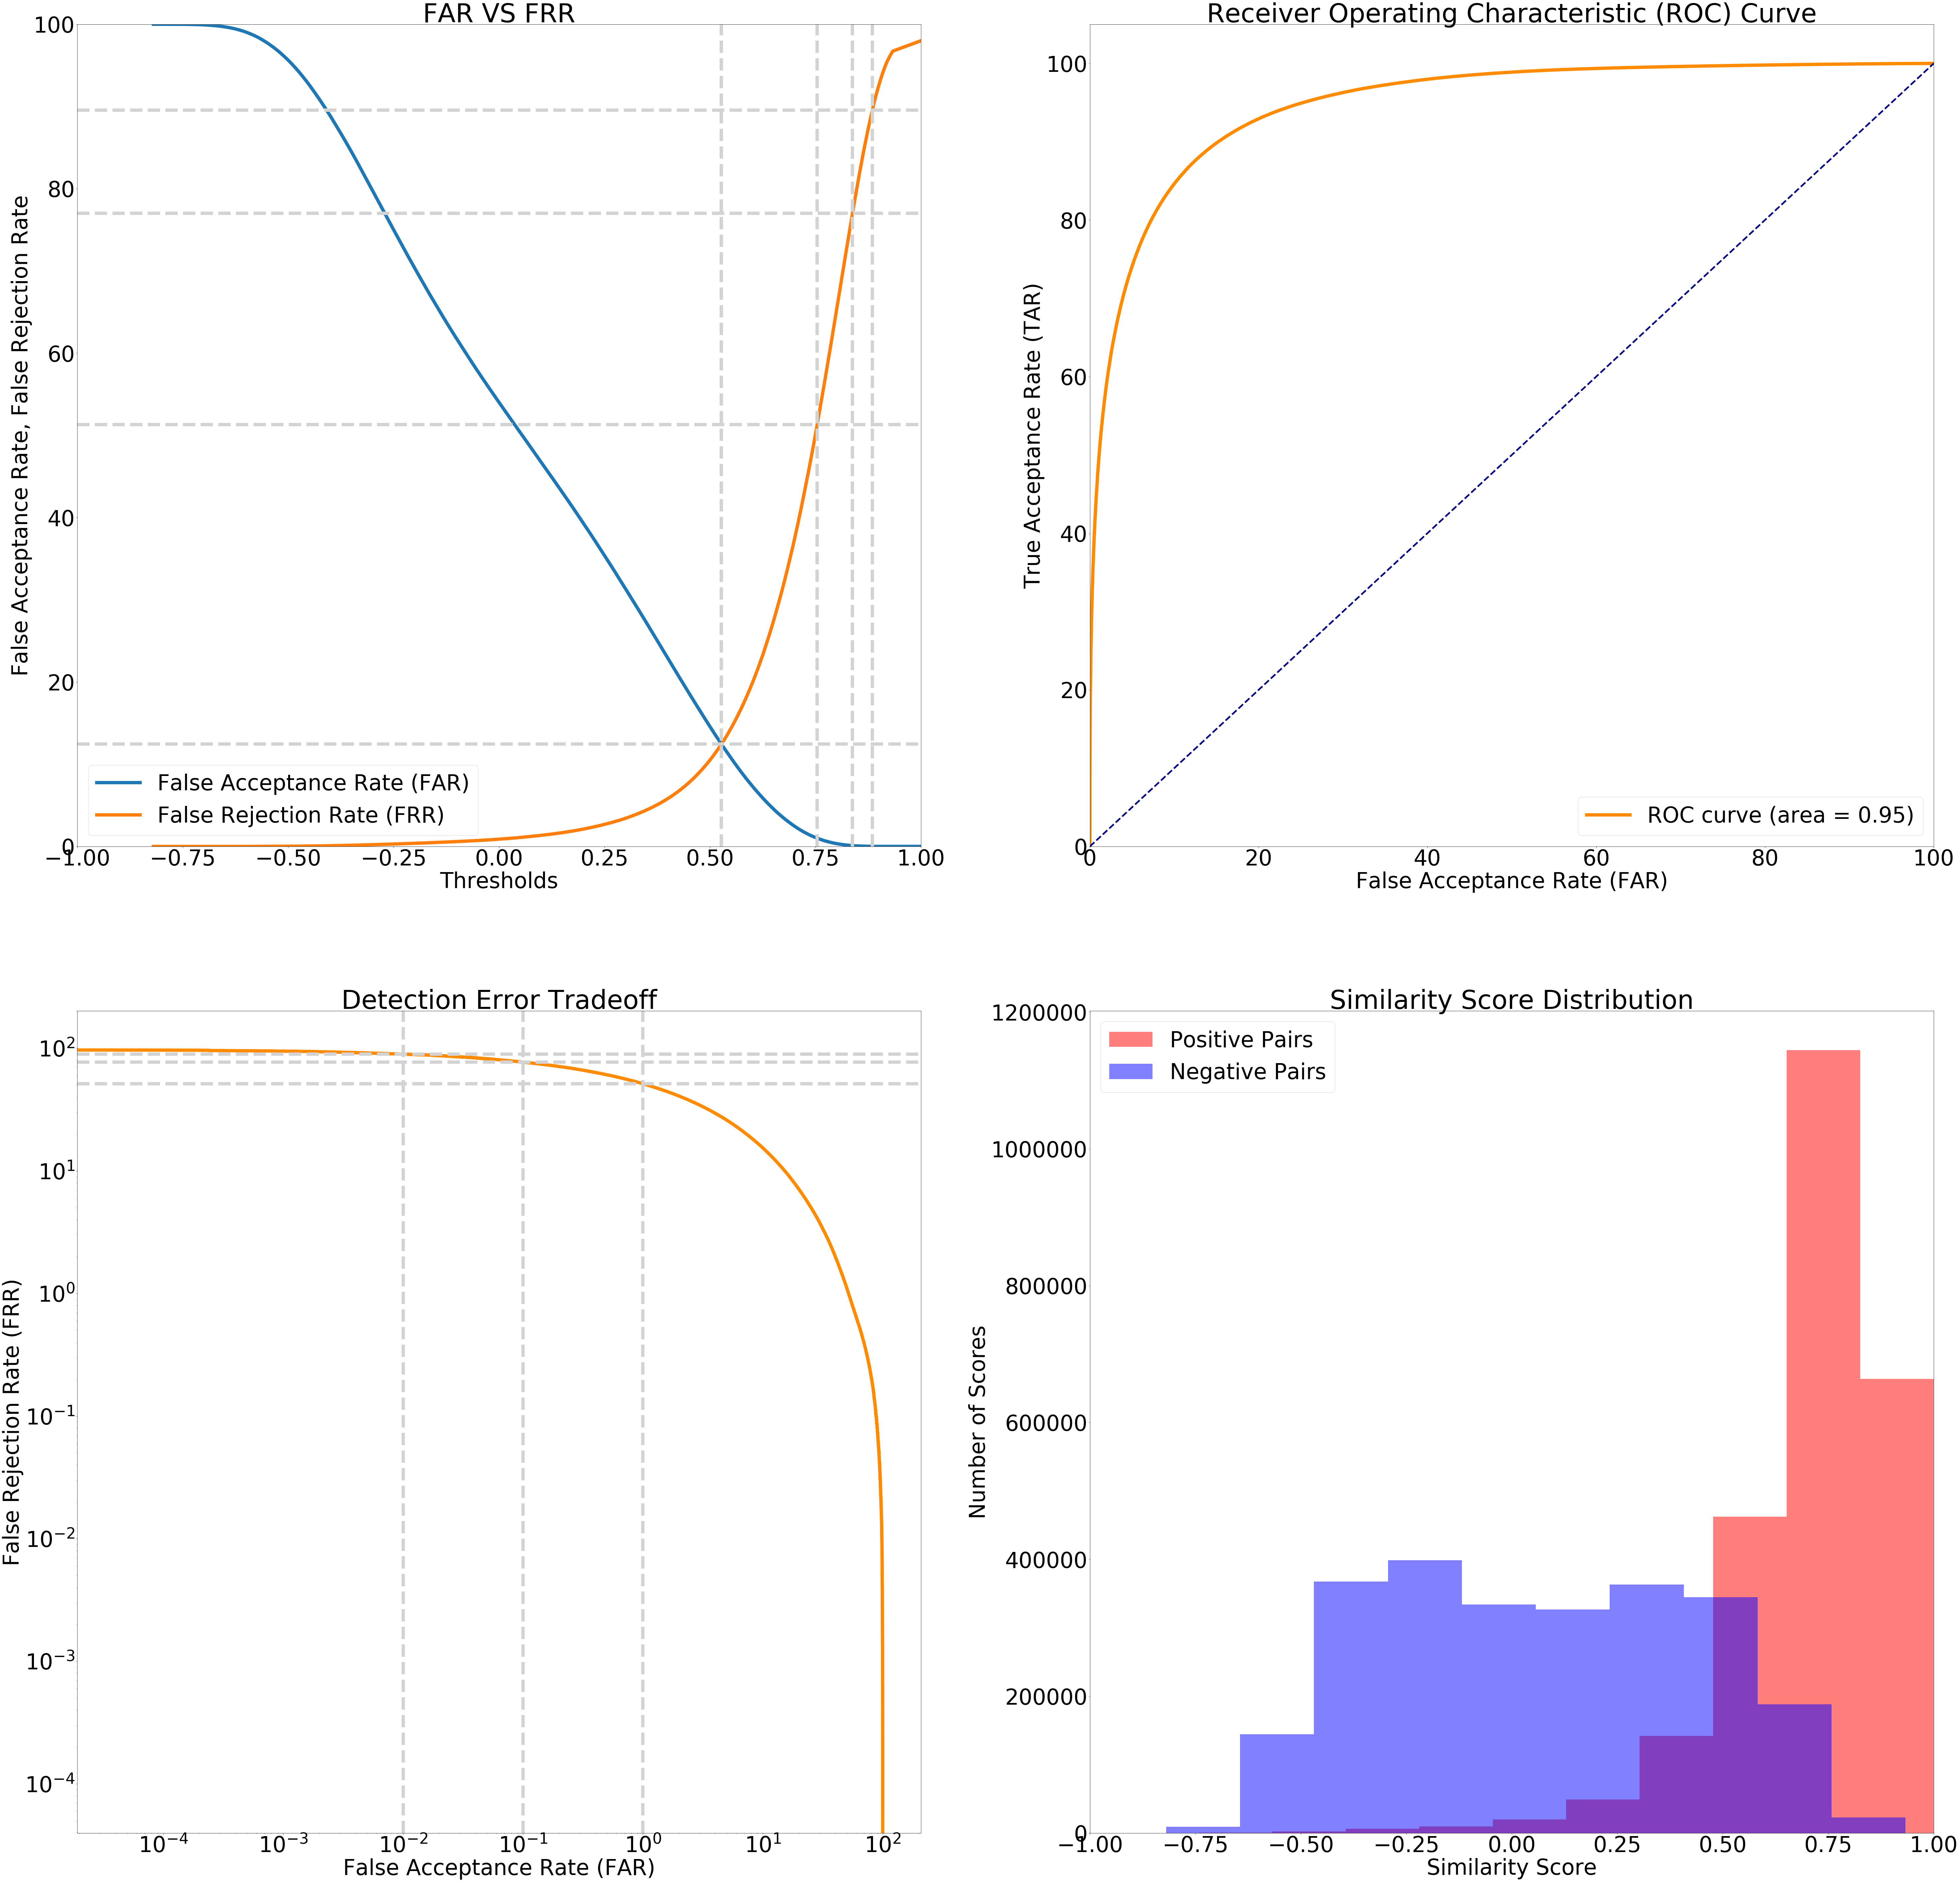

In [50]:
plt.rcParams.update({'font.size': 65})
plt.figure(figsize=(100, 100))

plt.subplot(221)
plt.title('FAR VS FRR')
plt.plot(thresholds, far * 100, label='False Acceptance Rate (FAR)', lw=10)
plt.plot(thresholds, frr * 100, label='False Rejection Rate (FRR)', lw=10)
plt.xlim([-1, 1])
plt.ylim([0, 100])
plt.ylabel('False Acceptance Rate, False Rejection Rate')
plt.xlabel('Thresholds')
plt.axvline(x=thresholds[np.argmin(np.abs(far - frr))], linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.01)], linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.001)], linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.0001)], linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[np.argmin(np.abs(far - frr))] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.01)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.001)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.0001)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.legend()

plt.subplot(222)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(far * 100, tpr * 100, color='darkorange', lw=10, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 100], [0, 100], color='navy', lw=5, linestyle='--')
plt.xlim([0.0, 100.0])
plt.ylim([0.0, 105.0])
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('True Acceptance Rate (TAR)')
plt.legend(loc="lower right")

plt.subplot(223)
plt.title('Detection Error Tradeoff')
plt.plot(far * 100, frr * 100, color='darkorange', lw=10)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.01)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.001)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.0001)] * 100, linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=1, linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=0.1, linestyle='--', lw=10, c='lightgrey')
plt.axvline(x=0.01, linestyle='--', lw=10, c='lightgrey')
plt.ylabel('False Rejection Rate (FRR)')
plt.xlabel('False Acceptance Rate (FAR)')

plt.subplot(224)
dist_pos = [scores[i] for i in range(len(scores)) if identical[i] == 1]
dist_neg = [scores[i] for i in range(len(scores)) if identical[i] == 0]
plt.title('Similarity Score Distribution')
plt.hist(dist_pos, fc=(1, 0, 0, 0.5), label='Positive Pairs', edgecolor='white')
plt.xlim([-1, 1])
plt.hist(dist_neg, fc=(0, 0, 1, 0.5), label='Negative Pairs')
plt.xlim([-1, 1])
plt.legend()
plt.xlabel('Similarity Score')
plt.ylabel('Number of Scores')

plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


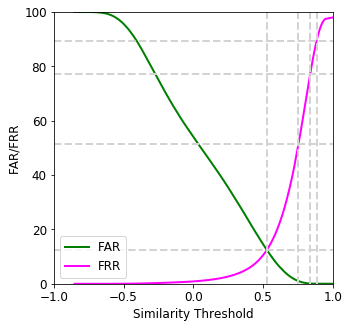

In [465]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
colors = ['green', 'magenta']
plt.plot(thresholds, far * 100, label='FAR', lw=2, color=colors[0])
plt.plot(thresholds, frr * 100, label='FRR', lw=2, color=colors[1])
plt.xlim([-1, 1])
plt.ylim([0, 100])
plt.ylabel('FAR/FRR')
plt.xlabel('Similarity Threshold')
plt.axvline(x=thresholds[np.argmin(np.abs(far - frr))], linestyle='--', lw=2, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.01)], linestyle='--', lw=2, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.001)], linestyle='--', lw=2, c='lightgrey')
plt.axvline(x=thresholds[findThresholdAtFAR(far, 0.0001)], linestyle='--', lw=2, c='lightgrey')
plt.axhline(y=frr[np.argmin(np.abs(far - frr))] * 100, linestyle='--', lw=2, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.01)] * 100, linestyle='--', lw=2, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.001)] * 100, linestyle='--', lw=2, c='lightgrey')
plt.axhline(y=frr[findThresholdAtFAR(far, 0.0001)] * 100, linestyle='--', lw=2, c='lightgrey')
plt.legend()
plt.savefig("exp_thres_vox.pdf", bbox_inches='tight')
tikz_save("exp_thres_vox.tex")
plt.show()

#### Calculating the distribution of the False Acceptance Rate (FAR) at different thresholds 

In [22]:
thresholds = [0.53, 0.75]

In [ ]:
utterances_per_person = 50
thr_false_acceptance_rates_per_person = {}

for thr in thresholds:
    print('\nThreshold', thr)
    thr_false_acceptance_rates_per_person[thr] = {}
    
    false_acceptance_count_per_person = np.zeros((len(train_paths), len(ordered_labels)))
    male_false_acceptance_count_per_person = np.zeros((len(train_paths), len(ordered_labels)))
    female_false_acceptance_count_per_person = np.zeros((len(train_paths), len(ordered_labels)))
    for p_index, path in enumerate(train_paths):
        print('\rStep ' + str(p_index+1) + '/' + str(len(train_paths)), end='')
        for u_index, u_label in enumerate(ordered_labels):
            if u_label != train_labels[p_index]:
                u_row = similarities[p_index,:]
                u_row = u_row[(u_index*utterances_per_person):(u_index*utterances_per_person+utterances_per_person)]
                fac = len([1 for s in u_row if s > thr])
                false_acceptance_count_per_person[p_index, u_index] = fac / utterances_per_person
                if u_index*utterances_per_person in males:
                    male_false_acceptance_count_per_person[p_index, u_index] = fac / utterances_per_person
                else:
                    female_false_acceptance_count_per_person[p_index, u_index] = fac / utterances_per_person
            
    thr_false_acceptance_rates_per_person[thr]['all'] = false_acceptance_count_per_person
    thr_false_acceptance_rates_per_person[thr]['mal'] = male_false_acceptance_count_per_person
    thr_false_acceptance_rates_per_person[thr]['fem'] = female_false_acceptance_count_per_person
    
    save_obj(thr_false_acceptance_rates_per_person, '../data/backup/vox2_thr_false_acceptance_rates_per_person.pkl')

In [21]:
thr_false_acceptance_rates_per_person = load_obj('../data/backup/vox2_thr_false_acceptance_rates_per_person.pkl')

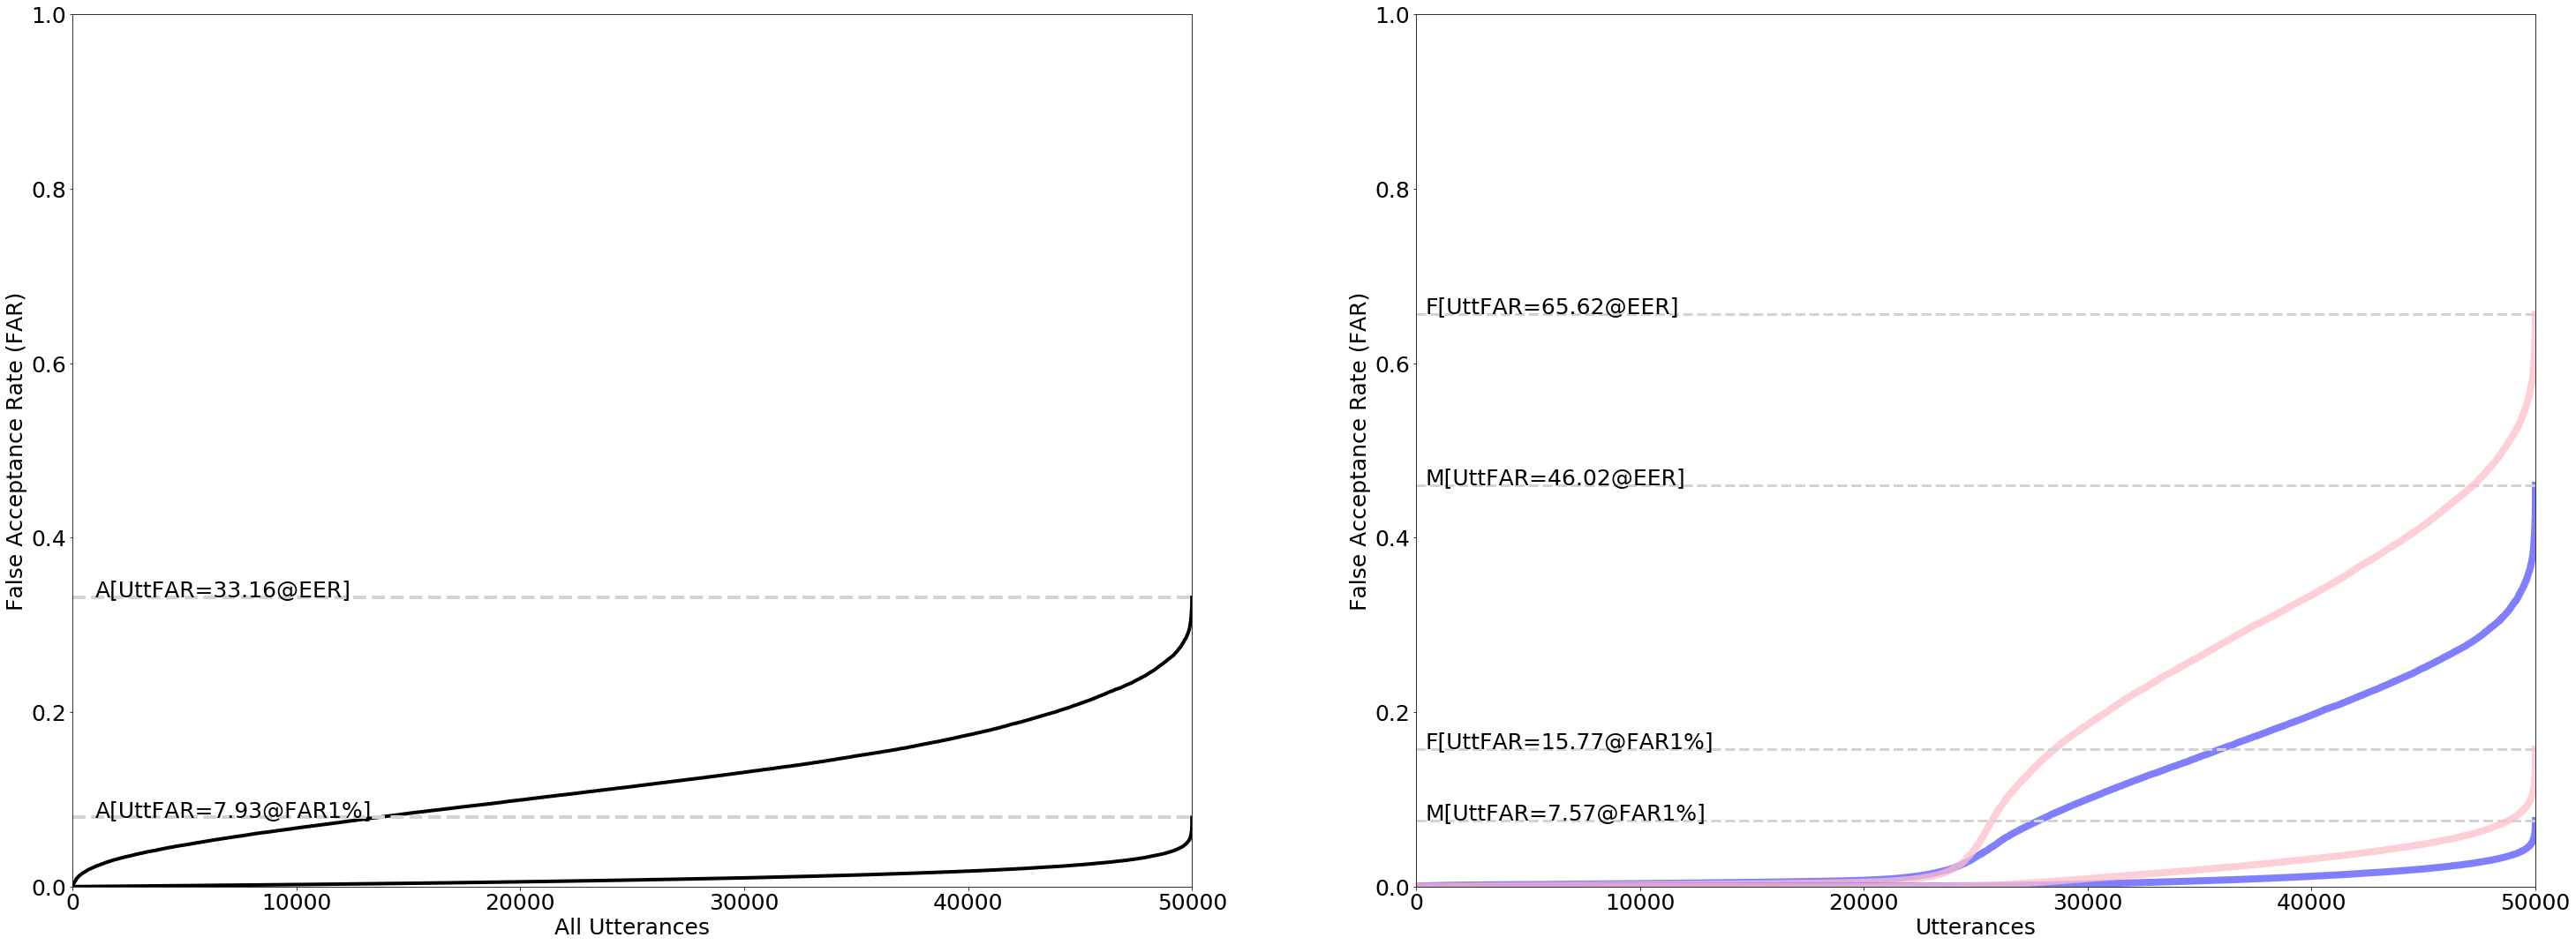

In [292]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(50, 40))
names = {0.53:'EER', 0.75:'FAR1%'}

plt.subplot(221)
plt.xlabel('All Utterances')
plt.ylabel('False Acceptance Rate (FAR)')
for k, v in thr_false_acceptance_rates_per_person.items():
    if k in list(names.keys()):
        false_acceptance_count = np.mean(v['all'], axis=1)
        sorted_false_acceptance_count = np.sort(false_acceptance_count)
        plt.plot(sorted_false_acceptance_count, lw=4, label='THR='+str(k), color=(0.0,0.0,0.0))
        plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=4, c='lightgrey')
        plt.text(1000, np.max(sorted_false_acceptance_count), 'A[UttFAR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1])

plt.subplot(222)
plt.xlabel('Utterances')
plt.ylabel('False Acceptance Rate (FAR)')
m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]
for k, v in thr_false_acceptance_rates_per_person.items():
    if k in list(names.keys()):
        get_mean = [np.mean(l[np.array(m)]) for l in v['mal']]
        false_acceptance_count = get_mean
        sorted_false_acceptance_count = np.sort(false_acceptance_count)
        plt.plot(sorted_false_acceptance_count, lw=8, color=(0.0,0.0,1.0), label='MalTHR='+str(k), alpha=0.5)
        plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
        plt.text(400, np.max(sorted_false_acceptance_count), 'M[UttFAR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
        get_mean = [np.mean(l[np.array(f)]) for l in v['fem']]
        false_acceptance_count = get_mean
        sorted_false_acceptance_count = np.sort(false_acceptance_count)
        plt.plot(sorted_false_acceptance_count, lw=8, color=(1.0,0.75,0.80), label='FemTHR='+str(k), alpha=0.75)
        plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
        plt.text(400, np.max(sorted_false_acceptance_count), 'F[UttFAR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1])
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


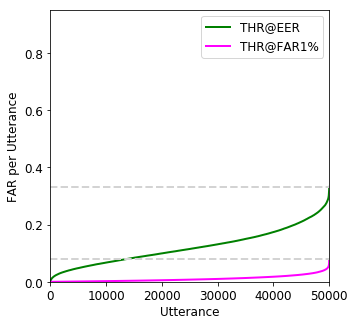

In [466]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
names = {0.53:'EER', 0.75:'FAR1%'}
colors = ['green', 'magenta']
linestyles = ['--', '--']
plt.xlabel('Utterance')
plt.ylabel('FAR per Utterance')
for i, (k, v) in enumerate(thr_false_acceptance_rates_per_person.items()):
    if k in list(names.keys()):
        false_acceptance_count = np.mean(v['all'], axis=1)
        sorted_false_acceptance_count = np.sort(false_acceptance_count)
        plt.plot(sorted_false_acceptance_count, lw=2, c=colors[i], label='THR@' + names[k])
        plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')
plt.xlim([0, 50000])
plt.ylim([0, 0.95])
plt.legend()
plt.savefig("exp_gfar_distr.pdf", bbox_inches='tight')
tikz_save("exp_gfar_distr.tex")
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


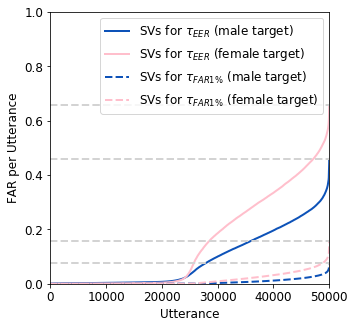

In [261]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
names = {0.53:'EER', 0.75:'FAR\\1%'}
colors = ['green', 'magenta']
linestyles = ['-', '--', ':']
plt.xlabel('Utterance')
plt.ylabel('FAR per Utterance')
utterances_per_person = 50
m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]

get_mean = [np.mean(l[np.array(m)]) for l in thr_false_acceptance_rates_per_person[0.53]['mal']]
false_acceptance_count = get_mean
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{EER}$ (male target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

get_mean = [np.mean(l[np.array(f)]) for l in thr_false_acceptance_rates_per_person[0.53]['fem']]
false_acceptance_count = get_mean
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{EER}$ (female target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

get_mean = [np.mean(l[np.array(m)]) for l in thr_false_acceptance_rates_per_person[0.75]['mal']]
false_acceptance_count = get_mean
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{FAR1\%}$ (male target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

get_mean = [np.mean(l[np.array(f)]) for l in thr_false_acceptance_rates_per_person[0.75]['fem']]
false_acceptance_count = get_mean
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{FAR1\%}$ (female target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

plt.xlim([0, 50000])
plt.ylim([0, 1])
plt.legend()
plt.savefig("exp_far_distrib.pdf", bbox_inches='tight')
tikz_save("exp_far_distrib.tex")
plt.show()

#### Calculating the distribution of the False Acceptance Rate per Person (FAR) at different thresholds 

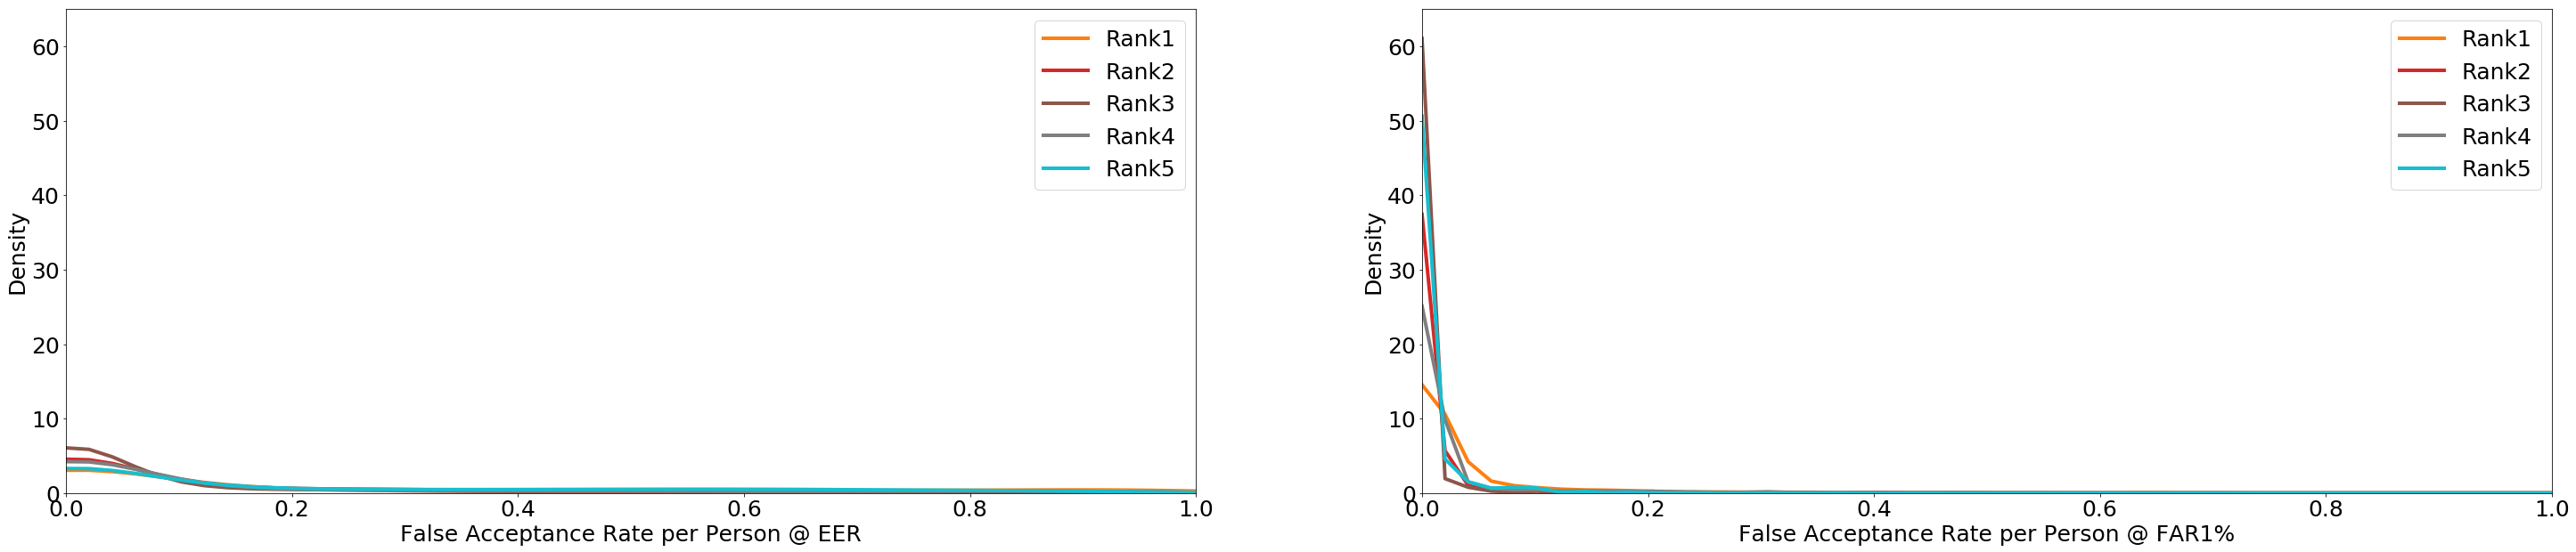

In [188]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(50, 10))

plt.subplot(121)
plt.xlabel('False Acceptance Rate per Person @ EER')
plt.ylabel('Density')
false_acceptance_count = thr_false_acceptance_rates_per_person[0.53]['all']
sorted_false_acceptance_count = np.sort(false_acceptance_count)
for i in range(5):
    density = stats.gaussian_kde(sorted_false_acceptance_count[i])
    n, x, _ = plt.hist(sorted_false_acceptance_count[i], bins=np.linspace(0, 1.0), histtype=u'step', density=True, alpha = 0.0)  
    plt.plot(x, density(x), lw=4, label='Rank'+str(i+1))
plt.xlim([0, 1.0])
plt.ylim([0, 65])
plt.legend()

plt.subplot(122)
plt.xlabel('False Acceptance Rate per Person @ FAR1%')
plt.ylabel('Density')
false_acceptance_count = thr_false_acceptance_rates_per_person[0.75]['all']
sorted_false_acceptance_count = np.sort(false_acceptance_count)
for i in range(5):
    density = stats.gaussian_kde(sorted_false_acceptance_count[i])
    n, x, _ = plt.hist(sorted_false_acceptance_count[i], bins=np.linspace(0, 1.0), histtype=u'step', density=True, alpha = 0.0)  
    plt.plot(x, density(x), lw=4, label='Rank'+str(i+1))
plt.xlim([0, 1.0])
plt.ylim([0, 65])
plt.legend()

plt.show()

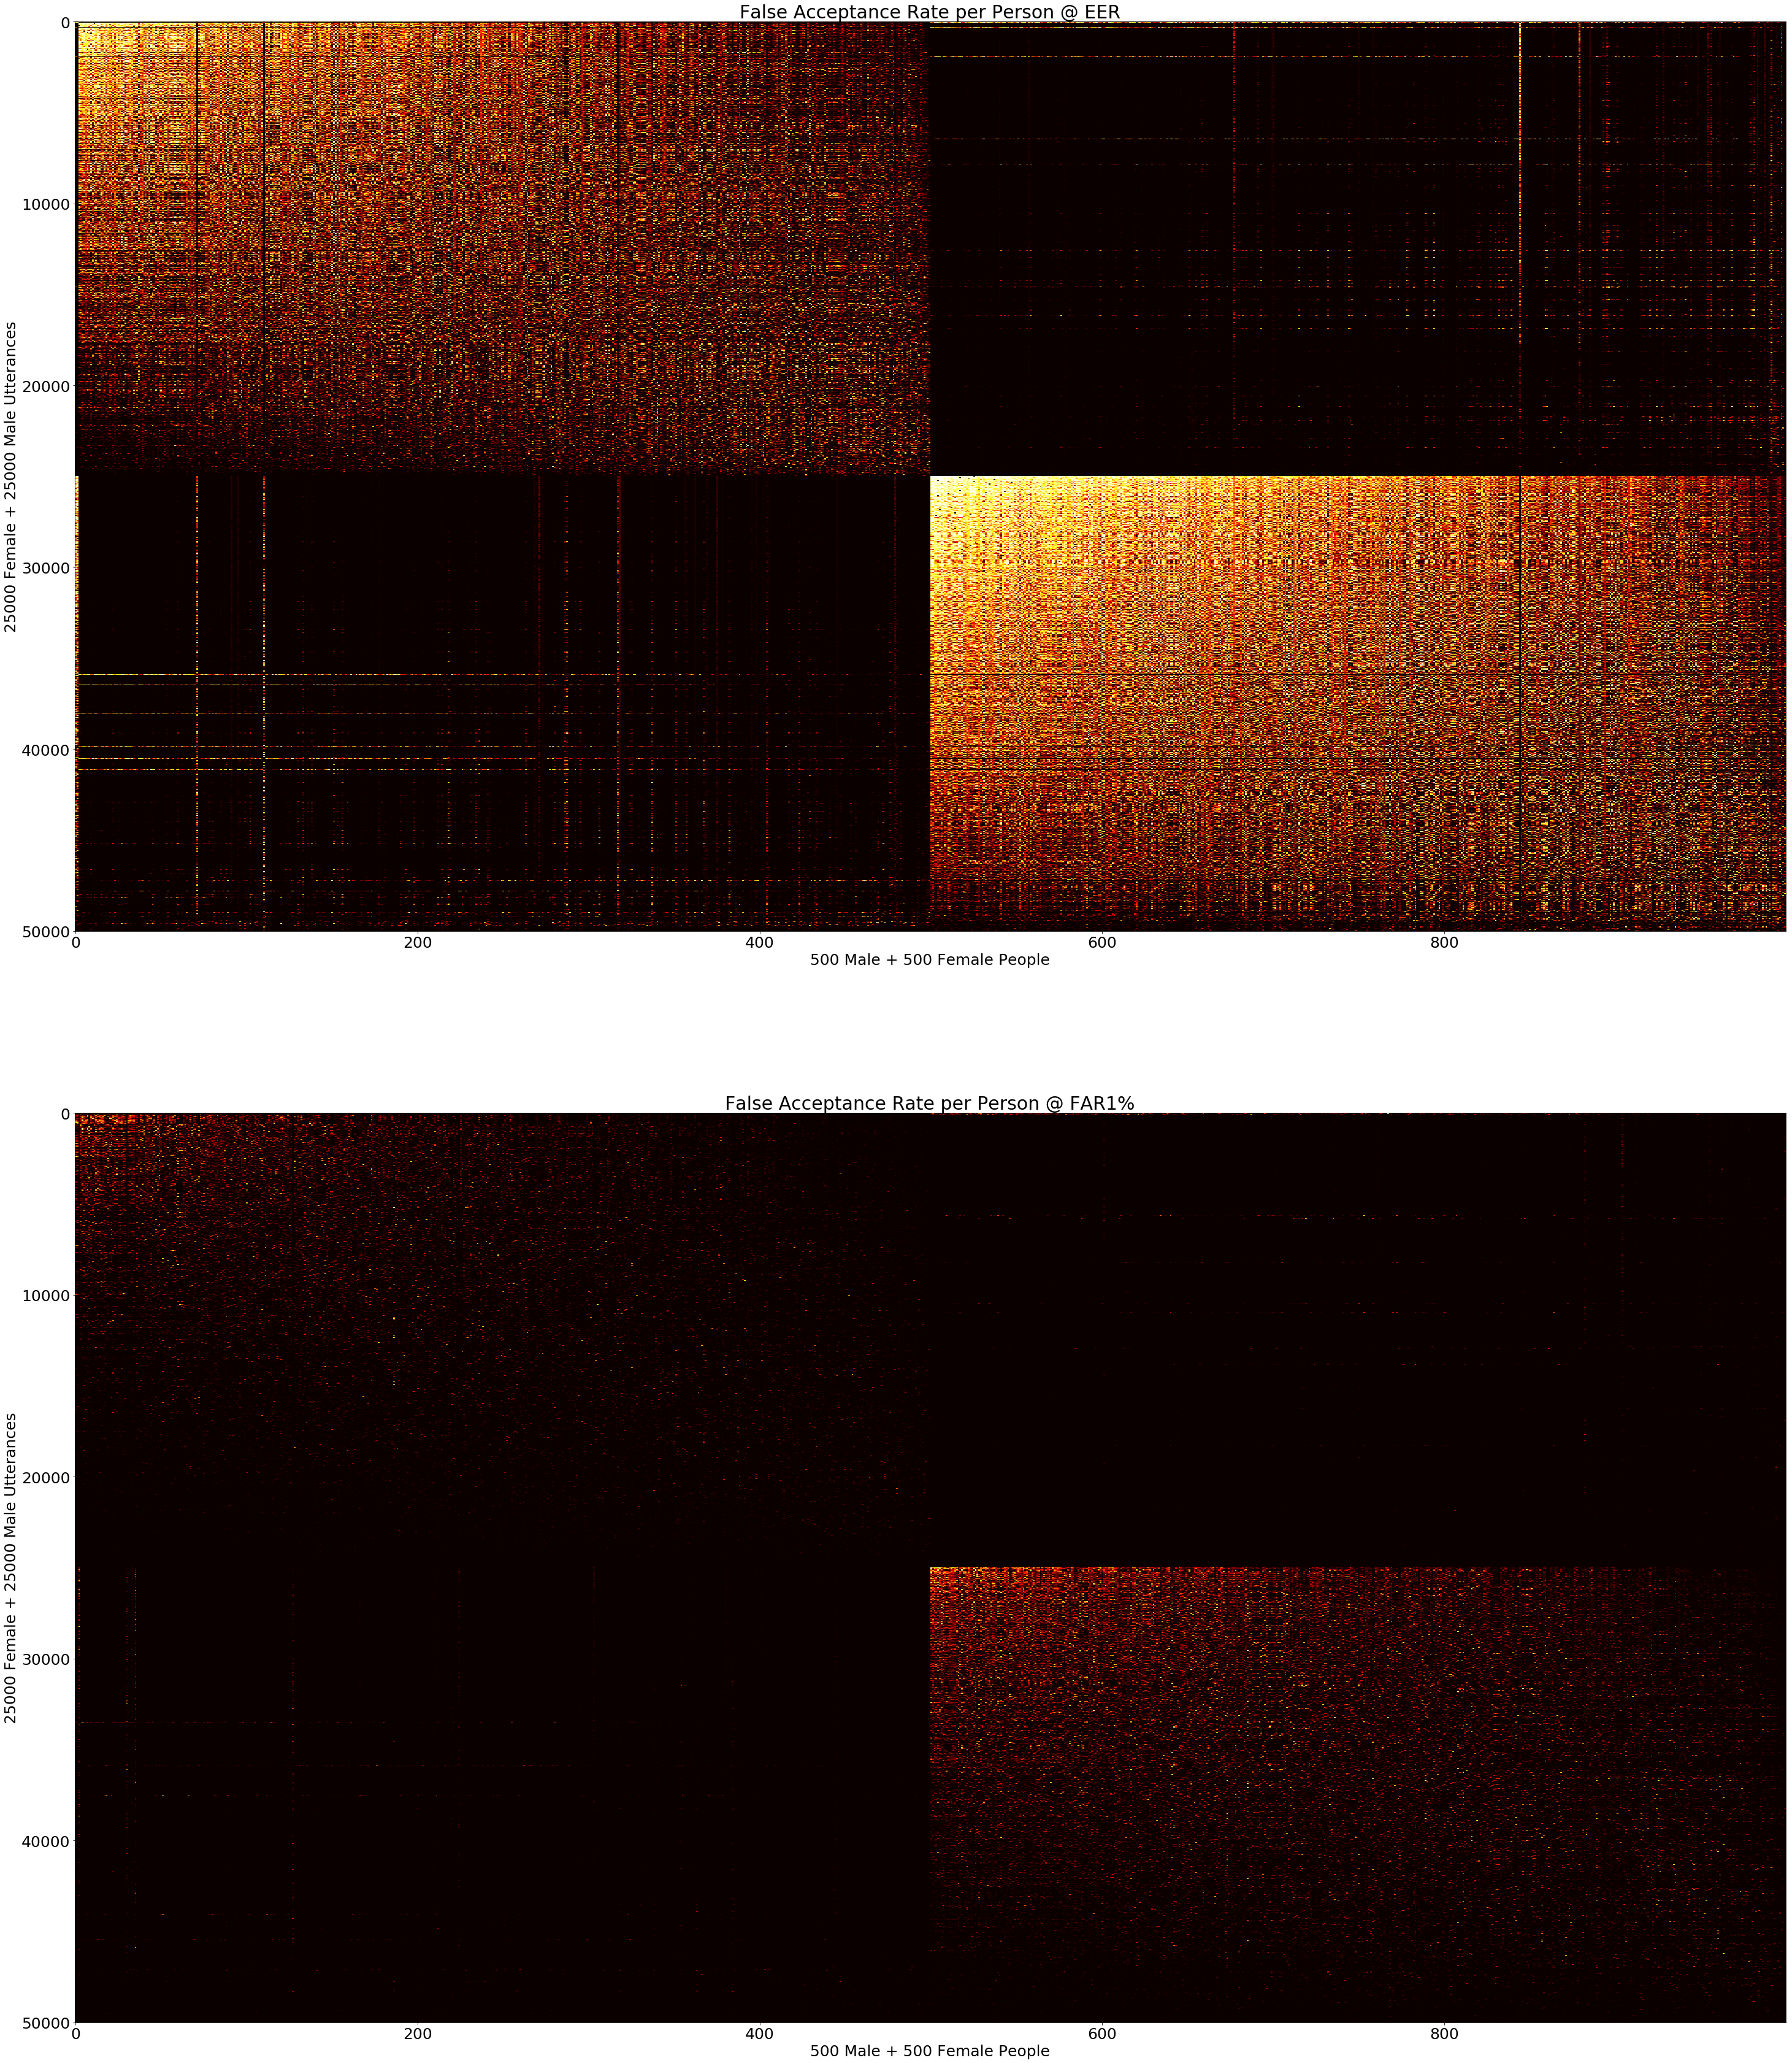

In [192]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(50, 60))

plt.subplot(211)
plt.title('False Acceptance Rate per Person @ EER')
plt.xlabel('500 Male + 500 Female People')
plt.ylabel('25000 Female + 25000 Male Utterances')

m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]

false_acceptance_count = thr_false_acceptance_rates_per_person[0.53]['all']

rank_false_acceptance_count = list(zip(males, false_acceptance_count[np.array(males),:], np.mean(false_acceptance_count[np.array(males),:], axis=1)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_males = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(m, false_acceptance_count[:,np.array(m)], np.sum(false_acceptance_count[:,np.array(m)], axis=0)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_males_columns = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(females, false_acceptance_count[np.array(females),:], np.mean(false_acceptance_count[np.array(females),:], axis=1)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_females = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(f, false_acceptance_count[:,np.array(f)], np.sum(false_acceptance_count[:,np.array(f)], axis=0)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_females_columns = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

false_acceptance_count = false_acceptance_count[np.array(sorted_males+sorted_females),:]
false_acceptance_count = false_acceptance_count[:,np.array(sorted_males_columns+sorted_females_columns)]

sorted_false_acceptance_count = false_acceptance_count
plt.imshow(sorted_false_acceptance_count, cmap='hot', aspect='auto')
    
plt.subplot(212)
plt.title('False Acceptance Rate per Person @ FAR1%')
plt.xlabel('500 Male + 500 Female People')
plt.ylabel('25000 Female + 25000 Male Utterances')

m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]

false_acceptance_count = thr_false_acceptance_rates_per_person[0.75]['all']

rank_false_acceptance_count = list(zip(males, false_acceptance_count[np.array(males),:], np.mean(false_acceptance_count[np.array(males),:], axis=1)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_males = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(m, false_acceptance_count[:,np.array(m)], np.sum(false_acceptance_count[:,np.array(m)], axis=0)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_males_columns = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(females, false_acceptance_count[np.array(females),:], np.mean(false_acceptance_count[np.array(females),:], axis=1)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_females = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

rank_false_acceptance_count = list(zip(f, false_acceptance_count[:,np.array(f)], np.sum(false_acceptance_count[:,np.array(f)], axis=0)))
rank_false_acceptance_count.sort(key=operator.itemgetter(2), reverse=True)
sorted_females_columns = [r[0] for i, r in enumerate(rank_false_acceptance_count)]

false_acceptance_count = false_acceptance_count[np.array(sorted_males+sorted_females),:]
false_acceptance_count = false_acceptance_count[:,np.array(sorted_males_columns+sorted_females_columns)]

sorted_false_acceptance_count = false_acceptance_count
plt.imshow(sorted_false_acceptance_count, cmap='hot', aspect='auto')

plt.show()

#### Calculating people impersonation rate at one-to-any rule 

In [19]:
thresholds = [0.53, 0.75]
enrolment_sizes = [10]
trials = 1
utterances_per_person = 50

In [ ]:
thr_impersonation_rates_any = {}

for thr in thresholds:
    print('\nThreshold', thr)
    thr_impersonation_rates_any[thr] = {}

    aev_impersonation_count = np.zeros((len(train_paths), len(enrolment_sizes)))
    aev_impersonation_count_m = np.zeros((len(train_paths), len(enrolment_sizes)))
    aev_impersonation_count_f = np.zeros((len(train_paths), len(enrolment_sizes)))
    for i, path in enumerate(train_paths):
        mv_similarities = similarities[i]
        for j, emb_size in enumerate(enrolment_sizes):
            counter = np.zeros(len(ordered_labels))
            for u_index, u_label in enumerate(ordered_labels):
                if u_label != train_labels[i]:
                    matches = 0
                    for trail in range(trials):
                        u_row = random.sample(list(mv_similarities[(u_index * utterances_per_person):(u_index * utterances_per_person + utterances_per_person)]), emb_size)
                        fac = len([1 for s in u_row if s > thr])
                        matches += (1 if fac > 0 else 0)
                    counter[u_index] = (1 if matches > trials / 2 else 0)
            print('\rStep', i, '/', len(train_paths), 'EmbS', emb_size, '/', len(enrolment_sizes) + 1, end='')
            aev_impersonation_count[i, j] = np.sum(counter)
            aev_impersonation_count_m[i, j] = np.sum([s for i, s in enumerate(counter) if i * utterances_per_person in males])
            aev_impersonation_count_f[i, j] = np.sum([s for i, s in enumerate(counter) if i * utterances_per_person in females])

    thr_impersonation_rates_any[thr]['all'] = aev_impersonation_count / len(ordered_labels)
    thr_impersonation_rates_any[thr]['mal'] = aev_impersonation_count_m / (len(ordered_labels) / 2)
    thr_impersonation_rates_any[thr]['fem'] = aev_impersonation_count_f / (len(ordered_labels) / 2)

In [ ]:
save_obj(thr_impersonation_rates_any, '../data/backup/vox2_thr_impersonation_rates_any.pkl')

In [23]:
thr_impersonation_rates_any = load_obj('../data/backup/vox2_thr_impersonation_rates_any.pkl')

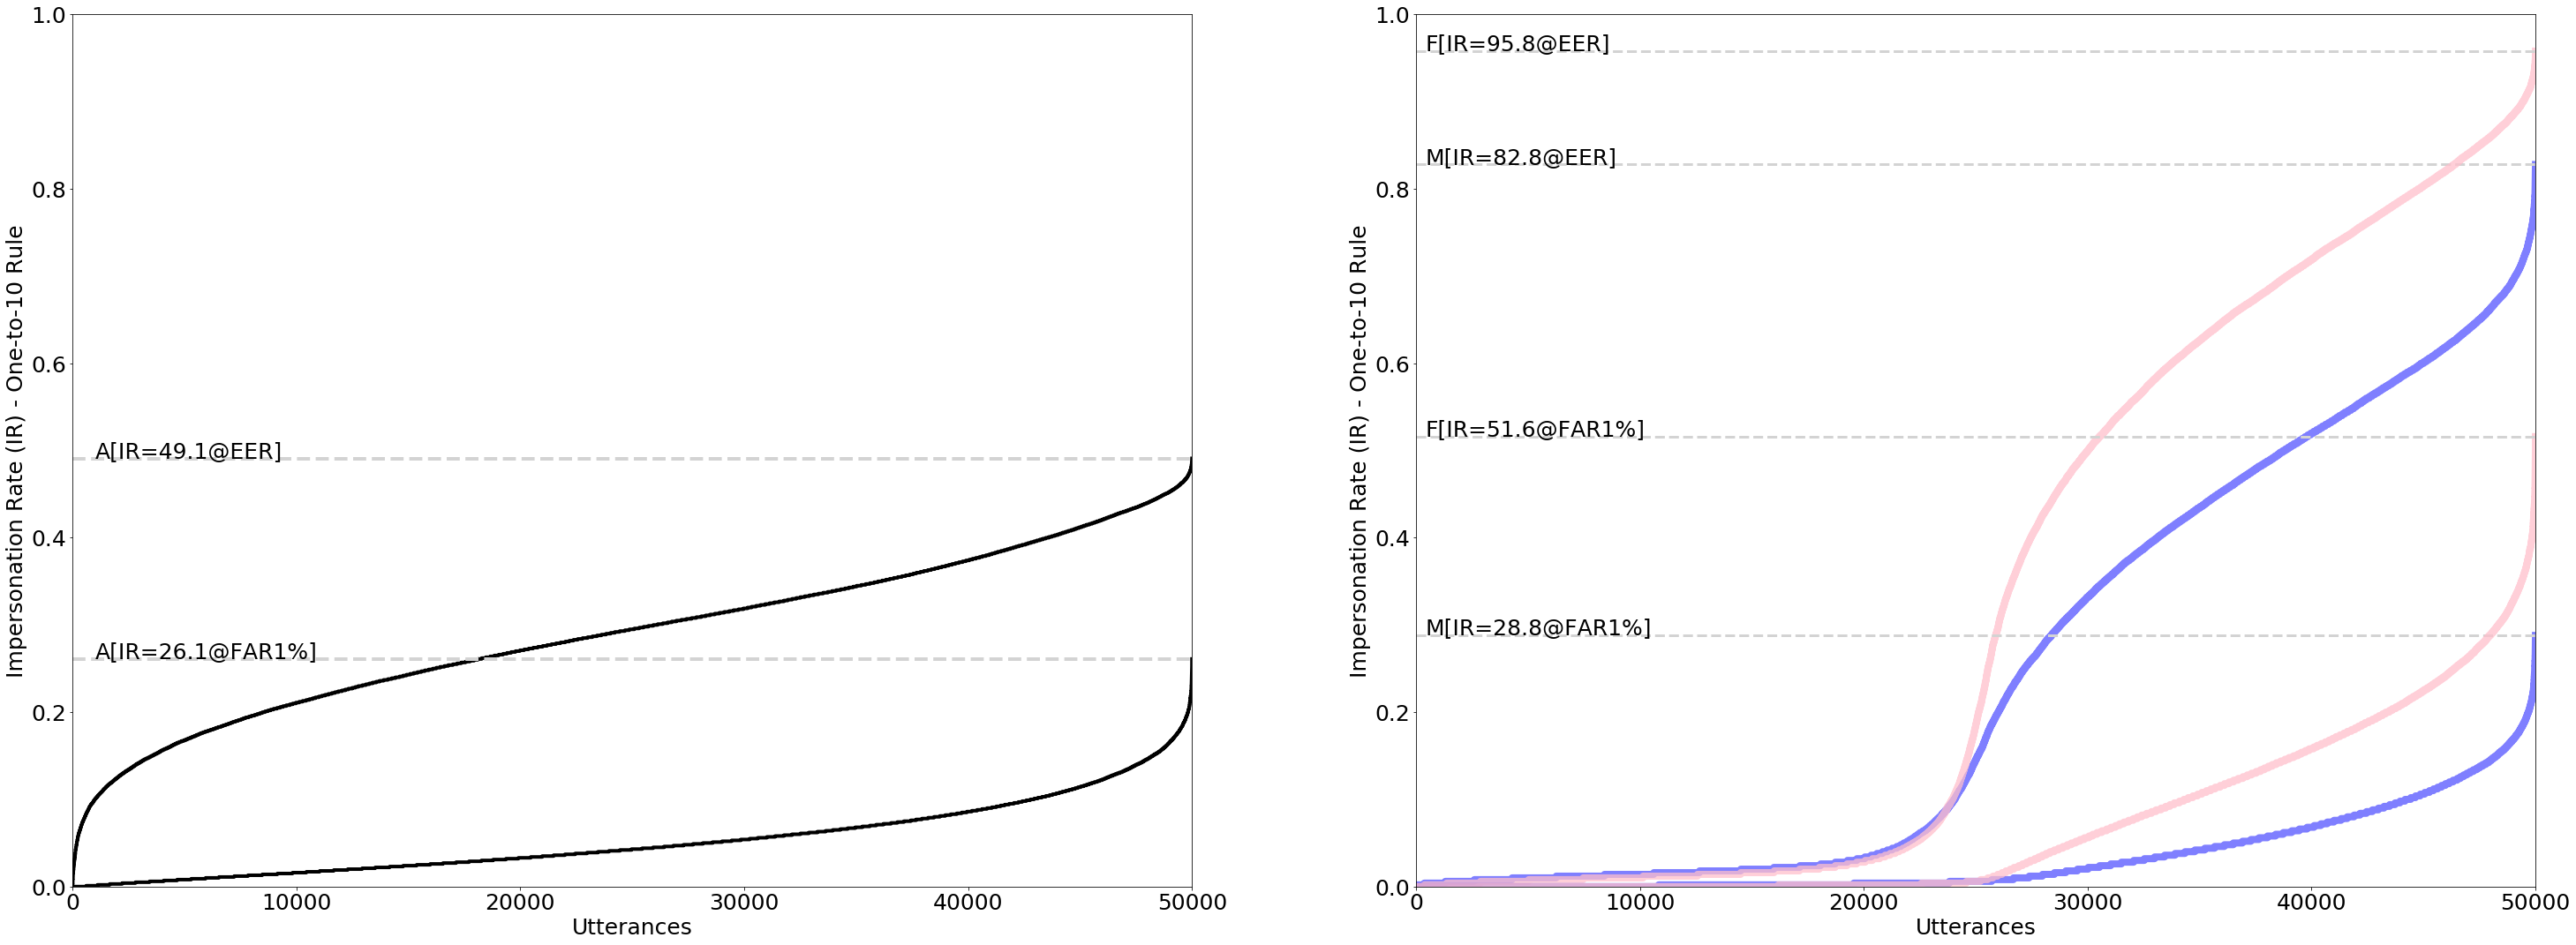

In [293]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(50, 40))
names = {0.53:'EER', 0.75:'FAR1%'}

plt.subplot(221)
plt.xlabel('Utterances')
plt.ylabel('Impersonation Rate (IR) - One-to-10 Rule')
for k, v in thr_impersonation_rates_any.items():
    false_acceptance_count = np.mean(v['all'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=4, label='THR='+str(k), color=(0.0,0.0,0.0))
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=4, c='lightgrey')
    plt.text(1000, np.max(sorted_false_acceptance_count), 'A[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1.0])

plt.subplot(222)
plt.xlabel('Utterances')
plt.ylabel('Impersonation Rate (IR) - One-to-10 Rule')
for k, v in thr_impersonation_rates_any.items():
    false_acceptance_count = np.mean(v['mal'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=8, color=(0.0,0.0,1.0), label='MalTHR='+str(k), alpha=0.5)
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
    plt.text(400, np.max(sorted_false_acceptance_count), 'M[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
    false_acceptance_count = np.mean(v['fem'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=8, color=(1.0,0.75,0.80), label='FemTHR='+str(k), alpha=0.75)
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
    plt.text(400, np.max(sorted_false_acceptance_count), 'F[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1.0])
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


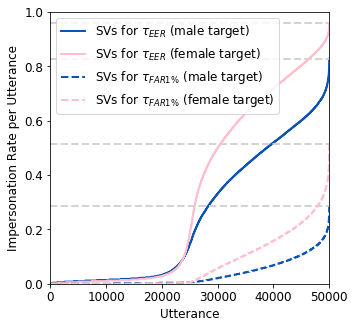

In [262]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
names = {0.53:'EER', 0.75:'FAR1%'}
colors = ['green', 'magenta']
linestyles = ['-', '--', ':']
plt.xlabel('Utterance')
plt.ylabel('Impersonation Rate per Utterance')
utterances_per_person = 50
m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]

false_acceptance_count = np.mean(thr_impersonation_rates_any[0.53]['mal'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{EER}$ (male target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_any[0.53]['fem'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{EER}$ (female target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_any[0.75]['mal'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{FAR1\%}$ (male target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_any[0.75]['fem'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{FAR1\%}$ (female target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')
    
plt.xlim([0, 50000])
plt.ylim([0, 1])
plt.legend()
plt.savefig("exp_any_distrib.pdf", bbox_inches='tight')
tikz_save("exp_any_distrib.tex")
plt.show()

#### Calculating people impersonation rate at one-to-avg rule 

In [24]:
thresholds = [0.53, 0.75]
enrolment_sizes = [10]
trials = 1

In [ ]:
thr_impersonation_rates_avg = {}

for thr in thresholds:
    print('\nThreshold', thr)
    thr_impersonation_rates_avg[thr] = {}
    
    aev_impersonation_count = np.zeros((len(train_paths), len(enrolment_sizes)))
    aev_impersonation_count_m = np.zeros((len(train_paths), len(enrolment_sizes)))
    aev_impersonation_count_f = np.zeros((len(train_paths), len(enrolment_sizes)))
    for i, path in enumerate(train_paths):
        emb_mv = embs[i]
        for j, emb_size in enumerate(enrolment_sizes):
            counter = np.zeros(len(ordered_labels))
            for u_index, u_label in enumerate(ordered_labels):
                if u_label != train_labels[i]:
                    matches = 0
                    for trail in range(trials):
                        u_embs = random.sample(list(embs[(u_index*utterances_per_person):(u_index*utterances_per_person+utterances_per_person)]), emb_size)
                        u_embs = np.mean(u_embs, axis=0)
                        s = 1 - spatial.distance.cosine(emb_mv, u_embs)
                        matches += (1 if s > tau else 0)
                    counter[u_index] = (1 if matches > trials / 2 else 0)
            print('\rStep', i, '/', len(train_paths), 'EmbS', emb_size, '/', len(enrolment_sizes) + 1, end='')
            aev_impersonation_count[i,j] = np.sum(counter)
            aev_impersonation_count_m[i,j] = np.sum([s for i,s in enumerate(counter) if i*utterances_per_person in males])
            aev_impersonation_count_f[i,j] = np.sum([s for i,s in enumerate(counter) if i*utterances_per_person in females])
            
    thr_impersonation_rates_avg[thr]['all'] = aev_impersonation_count / len(ordered_labels)
    thr_impersonation_rates_avg[thr]['mal'] = aev_impersonation_count_m / (len(ordered_labels) / 2)
    thr_impersonation_rates_avg[thr]['fem'] = aev_impersonation_count_f / (len(ordered_labels) / 2)

In [ ]:
save_obj(thr_impersonation_rates_avg, '../data/backup/vox2_thr_impersonation_rates_avg.pkl')

In [25]:
thr_impersonation_rates_avg = load_obj('../data/backup/vox2_thr_impersonation_rates_avg.pkl')

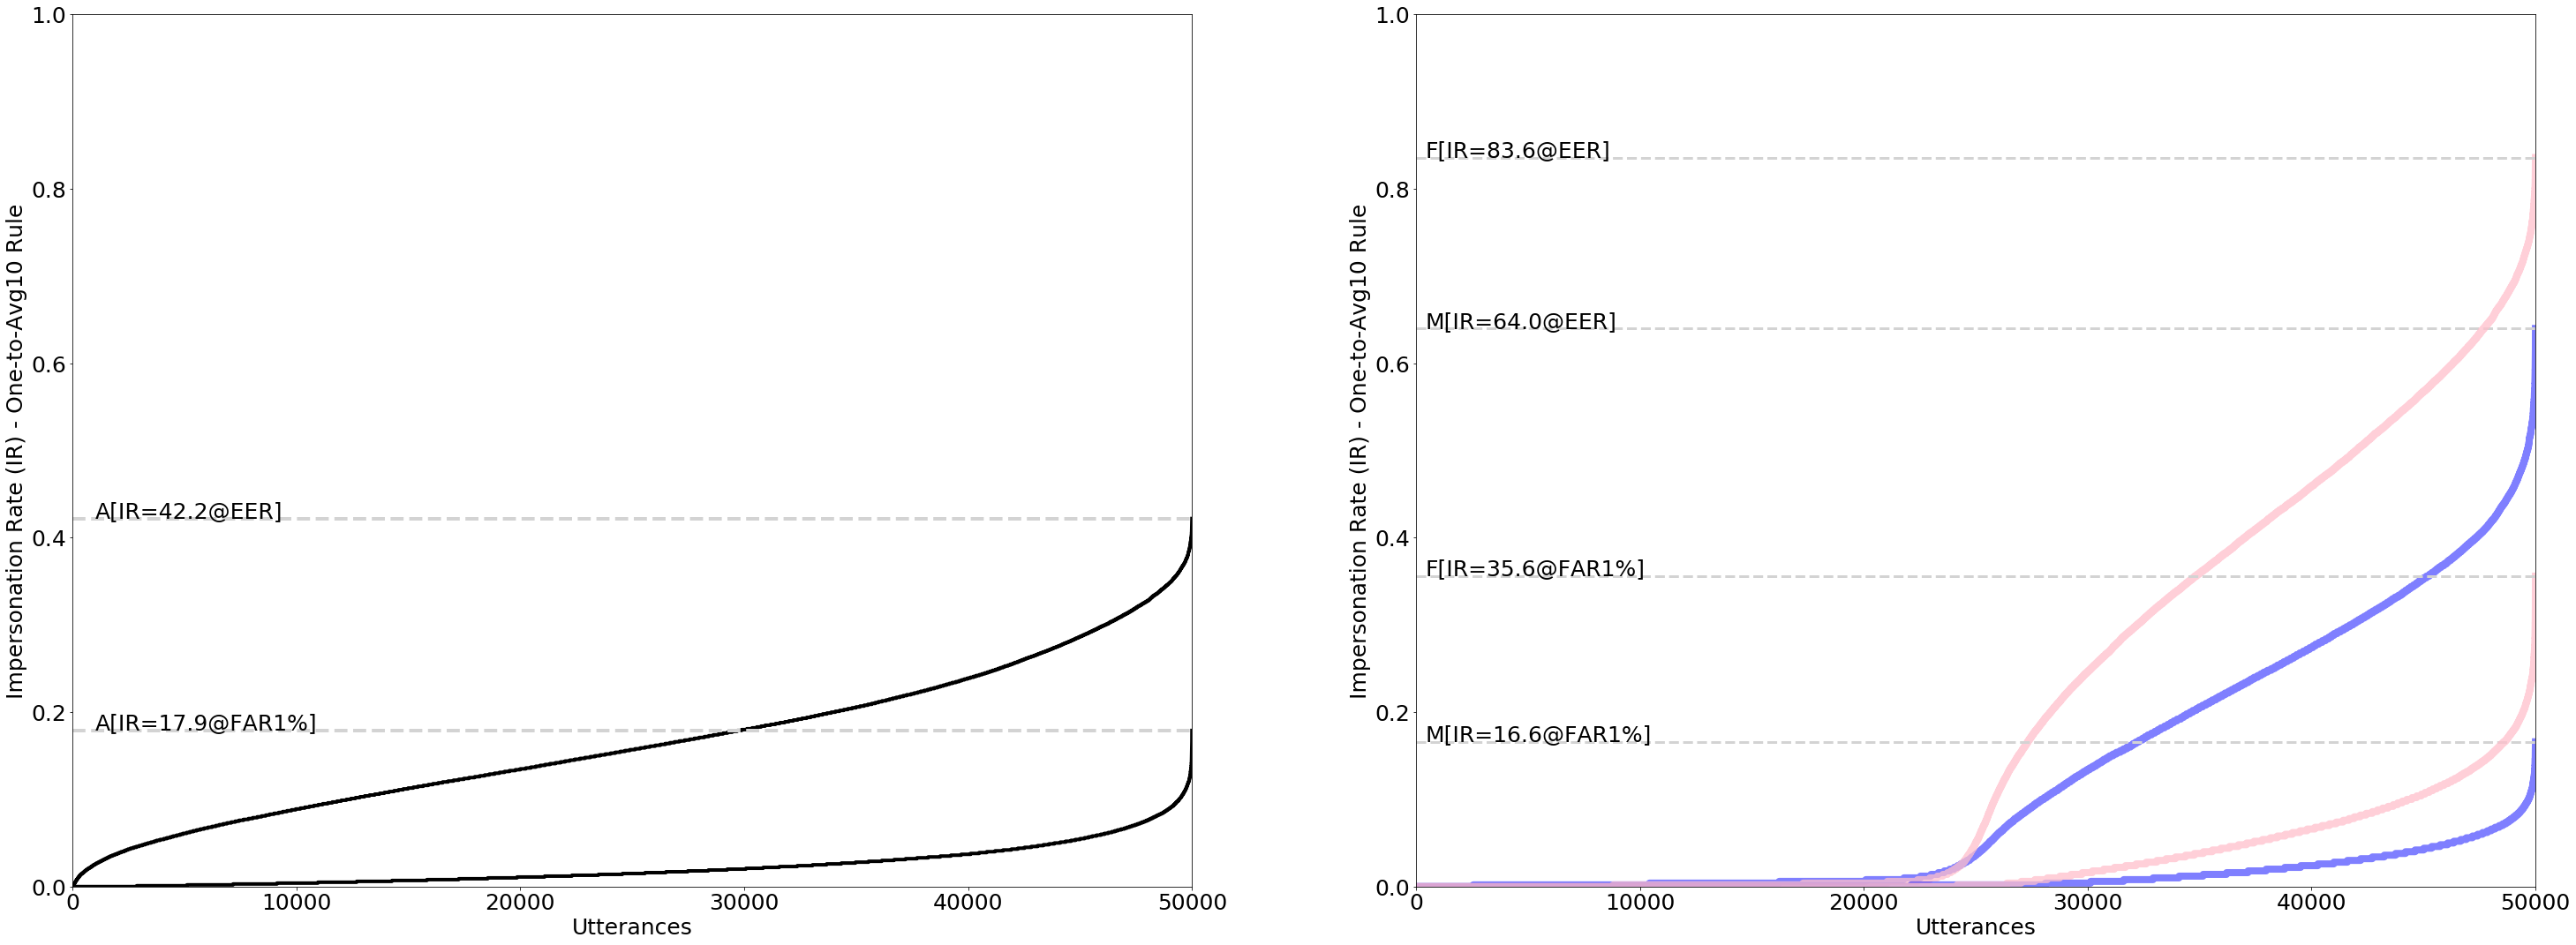

In [294]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(50, 40))
names = {0.53:'EER', 0.75:'FAR1%'}

plt.subplot(221)
plt.xlabel('Utterances')
plt.ylabel('Impersonation Rate (IR) - One-to-Avg10 Rule')
for k, v in thr_impersonation_rates_avg.items():
    false_acceptance_count = np.mean(v['all'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=4, label='THR='+str(k), color=(0.0,0.0,0.0))
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=4, c='lightgrey')
    plt.text(1000, np.max(sorted_false_acceptance_count), 'A[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1.0])

plt.subplot(222)
plt.xlabel('Utterances')
plt.ylabel('Impersonation Rate (IR) - One-to-Avg10 Rule')
for k, v in thr_impersonation_rates_avg.items():
    false_acceptance_count = np.mean(v['mal'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=8, color=(0.0,0.0,1.0), label='MalTHR='+str(k), alpha=0.5)
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
    plt.text(400, np.max(sorted_false_acceptance_count), 'M[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
    false_acceptance_count = np.mean(v['fem'], axis=1)
    sorted_false_acceptance_count = np.sort(false_acceptance_count)
    plt.plot(sorted_false_acceptance_count, lw=8, color=(1.0,0.75,0.80), label='FemTHR='+str(k), alpha=0.75)
    plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=3, c='lightgrey')
    plt.text(400, np.max(sorted_false_acceptance_count), 'F[IR=' + str(round(round(np.max(sorted_false_acceptance_count),4)*100, 2)) + '@'+ names[k] + ']')
plt.xlim([0, 50000])
plt.ylim([0, 1.00])
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


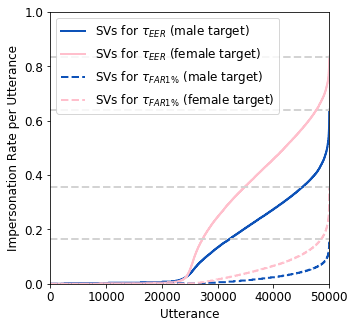

In [263]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
names = {0.53:'EER', 0.75:'FAR1%'}
colors = ['green', 'magenta']
linestyles = ['-', '--', ':']
plt.xlabel('Utterance')
plt.ylabel('Impersonation Rate per Utterance')
utterances_per_person = 50
m = [i for i in range(len(ordered_labels)) if i*utterances_per_person in males]
f = [i for i in range(len(ordered_labels)) if i*utterances_per_person in females]

false_acceptance_count = np.mean(thr_impersonation_rates_avg[0.53]['mal'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{EER}$ (male target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_avg[0.53]['fem'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{EER}$ (female target)', linestyle=linestyles[0])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_avg[0.75]['mal'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(0.05,0.32,0.72), label=r'SVs for $\tau_{FAR1\%}$ (male target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')

false_acceptance_count = np.mean(thr_impersonation_rates_avg[0.75]['fem'], axis=1)
sorted_false_acceptance_count = np.sort(false_acceptance_count)
plt.plot(sorted_false_acceptance_count, lw=2, color=(1.0,0.75,0.80), label=r'SVs for $\tau_{FAR1\%}$ (female target)', linestyle=linestyles[1])
plt.axhline(y=np.max(sorted_false_acceptance_count), linestyle='--', lw=2, c='lightgrey')
    

plt.xlim([0, 50000])
plt.ylim([0, 1])
plt.legend()
plt.savefig("exp_avg_distrib.pdf", bbox_inches='tight')
tikz_save("exp_avg_distrib.tex")
plt.show()

#### Sampling based on False Acceptance Rate (FAR)

In [31]:
thr_false_acceptance_rate = load_obj('../data/backup/vox2_thr_false_acceptance_rates.pkl')

In [206]:
far_m = [v for i,v in enumerate(thr_false_acceptance_rate[0.53]['all']) if i*50 in males]
far_f = [v for i,v in enumerate(thr_false_acceptance_rate[0.53]['all']) if i*50 in females]

In [207]:
head_n = 10
base_ranking = thr_false_acceptance_rate[0.53]['all']
ranking_males = list(zip(range(len(train_paths)), train_paths, base_ranking))
ranking_males =  [v for i,v in enumerate(ranking_males) if v[0]*50 in males]
ranking_males.sort(key=operator.itemgetter(2), reverse=True)
for rank, (path_id, path, count) in enumerate(ranking_males[:head_n]):
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    print('Rank #' + str(rank+1).rjust(2), path_id, path, 'is a', 'male' if gender == 'm' else 'female', 'and has a FAR of', str(round(count*100, 2)), '%')

Rank # 1 26 ../data/voxceleb2/dev/id02331/B_8JVYCYZpY/00043.m4a is a female and has a FAR of 28.76 %
Rank # 2 150 ../data/voxceleb2/dev/id04152/QzC-VeVQ45A/00031.m4a is a female and has a FAR of 27.52 %
Rank # 3 725 ../data/voxceleb2/dev/id01515/pusKvNvIAnA/00042.m4a is a female and has a FAR of 27.19 %
Rank # 4 671 ../data/voxceleb2/dev/id04908/wuaPa9ew1J0/00084.m4a is a female and has a FAR of 27.01 %
Rank # 5 27 ../data/voxceleb2/dev/id02331/dtwDUkTc7dY/00078.m4a is a female and has a FAR of 26.37 %
Rank # 6 460 ../data/voxceleb2/dev/id03622/ZLd8pDHfx3Y/00041.m4a is a female and has a FAR of 23.25 %
Rank # 7 189 ../data/voxceleb2/dev/id04152/wCBZkAQXsWw/00089.m4a is a female and has a FAR of 22.87 %
Rank # 8 198 ../data/voxceleb2/dev/id04152/tht75ObIj3c/00081.m4a is a female and has a FAR of 22.82 %
Rank # 9 159 ../data/voxceleb2/dev/id04152/wCBZkAQXsWw/00092.m4a is a female and has a FAR of 22.65 %
Rank #10 693 ../data/voxceleb2/dev/id04908/qTDbhfrG7xU/00075.m4a is a female and has

In [208]:
head_n = 10
base_ranking = thr_false_acceptance_rate[0.53]['all']
ranking_females = list(zip(range(len(train_paths)), train_paths, base_ranking))
ranking_females =  [v for i,v in enumerate(ranking_females) if v[0]*50 in females]
ranking_females.sort(key=operator.itemgetter(2), reverse=True)
for rank, (path_id, path, count) in enumerate(ranking_females[:head_n]):
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    print('Rank #' + str(rank+1).rjust(2), path_id, path, 'is a', 'male' if gender == 'm' else 'female', 'and has a FAR of', str(round(count*100, 2)), '%')

Rank # 1 684 ../data/voxceleb2/dev/id04908/Fc0P8sp81GI/00031.m4a is a female and has a FAR of 30.22 %
Rank # 2 185 ../data/voxceleb2/dev/id04152/cxr3Fndyx18/00061.m4a is a female and has a FAR of 28.85 %
Rank # 3 662 ../data/voxceleb2/dev/id04908/WcMosojFdPE/00070.m4a is a female and has a FAR of 27.77 %
Rank # 4 449 ../data/voxceleb2/dev/id04910/uhij7Qz7DLI/00068.m4a is a female and has a FAR of 25.8 %
Rank # 5 690 ../data/voxceleb2/dev/id04908/qTDbhfrG7xU/00072.m4a is a female and has a FAR of 25.75 %
Rank # 6 9 ../data/voxceleb2/dev/id02331/6lVq9sU9o-8/00037.m4a is a female and has a FAR of 25.12 %
Rank # 7 657 ../data/voxceleb2/dev/id04908/0Kw84y30naI/00011.m4a is a female and has a FAR of 24.0 %
Rank # 8 651 ../data/voxceleb2/dev/id04908/x6OjvXcp6VI/00085.m4a is a female and has a FAR of 23.83 %
Rank # 9 692 ../data/voxceleb2/dev/id04908/T1rWYEiVWeg/00064.m4a is a female and has a FAR of 23.71 %
Rank #10 685 ../data/voxceleb2/dev/id04908/WcMosojFdPE/00065.m4a is a female and has a

#### Sampling the independent master voices

In [338]:
def grouper(in_list, step=3):
    return [in_list[i:i+step] for i in range(0, len(in_list), step)]

In [344]:
def get_bin(in_list, user_id):
    count = 0
    for i, l in enumerate(in_list):
        if user_id.split('/')[4] in l[1].split('/')[4]:
            count += 1
    return count

#### Males

In [26]:
head_n = 10
base_ranking = np.mean(thr_impersonation_rates_any[0.53]['mal'], axis=1)
ranking_males = list(zip(range(len(train_paths)), train_paths, base_ranking))
ranking_males.sort(key=operator.itemgetter(2), reverse=True)
for rank, (path_id, path, count) in enumerate(ranking_males[:head_n]):
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    print('Rank #' + str(rank+1).rjust(2), path, 'is a', 'male' if gender == 'm' else 'female', 'and impersonates', str(round(count*100, 2))+'%', 'males')

Rank # 1 ../data/voxceleb2/dev/id01205/xFEiV_DSFdo/00056.m4a is a male and impersonates 82.8% males
Rank # 2 ../data/voxceleb2/dev/id02258/OO1TraDxZFk/00039.m4a is a male and impersonates 82.6% males
Rank # 3 ../data/voxceleb2/dev/id06509/Tin1n-Wdlck/00076.m4a is a male and impersonates 82.6% males
Rank # 4 ../data/voxceleb2/dev/id04926/QU2mWh5JWUY/00020.m4a is a male and impersonates 82.4% males
Rank # 5 ../data/voxceleb2/dev/id04926/QU2mWh5JWUY/00017.m4a is a male and impersonates 82.2% males
Rank # 6 ../data/voxceleb2/dev/id09007/IK2mV7IW-7A/00002.m4a is a male and impersonates 82.2% males
Rank # 7 ../data/voxceleb2/dev/id02258/0juW_NAx_cQ/00007.m4a is a male and impersonates 82.0% males
Rank # 8 ../data/voxceleb2/dev/id04093/0lN_x-NCC2E/00008.m4a is a male and impersonates 81.4% males
Rank # 9 ../data/voxceleb2/dev/id01876/ULeALSKsj7o/00046.m4a is a male and impersonates 81.2% males
Rank #10 ../data/voxceleb2/dev/id09007/KRbntAUs5a0/00014.m4a is a male and impersonates 81.0% males


In [435]:
n_bins = 100
ranking_per_users = np.zeros((len(ordered_labels), n_bins))
ranking_bins = grouper(ranking_males, len(train_paths) // n_bins)
for u_index, u_label in enumerate(ordered_labels):
    print('\rStep', u_index, '/', len(ordered_labels), end='')
    path = train_paths[u_index*50]
    for r_index, r_bins in enumerate(ranking_bins):
        ranking_per_users[u_index, r_index] = get_bin(r_bins, path)

Step 999 / 1000

In [ ]:
m = [i for i in range(len(ordered_labels)) if i*50 in males]
only_males = ranking_per_users[m,:n_bins//2]
rank_only_males = list(zip(only_males, np.sum(only_males[:,:n_bins//4], axis=1)))
rank_only_males.sort(key=operator.itemgetter(1), reverse=True)
only_males = np.array([r[0] for i, r in enumerate(rank_only_males)])
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
colors=['#ffffff','#e5ecf9','#ccd9f4','#b2c6ef','#99b3ea','#7fa0e5','#668de0','#4c7adb','#3266d6','#1954d1','#0041cc']
heatmap = plt.pcolor(only_males.T, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar(heatmap, ticks=[0, 5, 10, 15, 20])
plt.xlabel('Male Users')
plt.ylabel('500D Male Utterance Bins')
plt.savefig("exp_rank_male.pdf", bbox_inches='tight')
tikz_save("exp_rank_male.tex")
plt.show()

#### Females

In [27]:
head_n = 10
base_ranking = np.mean( thr_impersonation_rates_any[0.53]['fem'], axis=1)
ranking_females = list(zip(range(len(train_paths)), train_paths, base_ranking))
ranking_females.sort(key=operator.itemgetter(2), reverse=True)
for rank, (path_id, path, count) in enumerate(ranking_females[:head_n]):
    gender = vox_meta.loc[vox_meta.vid == path.split('/')[4], 'gender'].values[0]
    print('Rank #' + str(rank+1).rjust(2), path, 'is a', 'male' if gender == 'm' else 'female', 'and impersonates', str(round(count*100, 2))+'%', 'females')

Rank # 1 ../data/voxceleb2/dev/id00624/ntg2XnUgC0g/00059.m4a is a female and impersonates 95.8% females
Rank # 2 ../data/voxceleb2/dev/id06914/qTZ3NO8erxA/00075.m4a is a female and impersonates 95.6% females
Rank # 3 ../data/voxceleb2/dev/id04908/Fc0P8sp81GI/00031.m4a is a female and impersonates 95.2% females
Rank # 4 ../data/voxceleb2/dev/id06393/Q7gsnTtzJv0/00035.m4a is a female and impersonates 95.2% females
Rank # 5 ../data/voxceleb2/dev/id00403/RMlG9WiT3fw/00040.m4a is a female and impersonates 95.0% females
Rank # 6 ../data/voxceleb2/dev/id01409/sF-3hM4Ne1U/00069.m4a is a female and impersonates 95.0% females
Rank # 7 ../data/voxceleb2/dev/id04641/unxhCjkHP9Q/00072.m4a is a female and impersonates 95.0% females
Rank # 8 ../data/voxceleb2/dev/id01833/GLtoQHWdZeE/00004.m4a is a female and impersonates 95.0% females
Rank # 9 ../data/voxceleb2/dev/id00399/xBHWtFYpjQ0/00086.m4a is a female and impersonates 95.0% females
Rank #10 ../data/voxceleb2/dev/id07996/B96TEJQfu50/00020.m4a is 

In [437]:
n_bins = 100
ranking_per_users = np.zeros((len(ordered_labels), n_bins))
ranking_bins = grouper(ranking_females, len(train_paths) // n_bins)
for u_index, u_label in enumerate(ordered_labels):
    print('\rStep', u_index, '/', len(ordered_labels), end='')
    path = train_paths[u_index*50]
    for r_index, r_bins in enumerate(ranking_bins):
        ranking_per_users[u_index, r_index] = get_bin(r_bins, path)

Step 999 / 1000

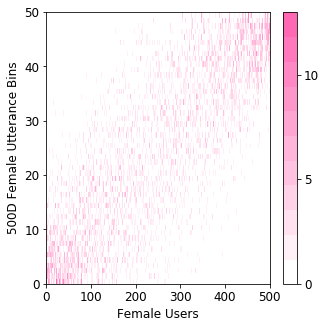

In [438]:
f = [i for i in range(len(ordered_labels)) if i*50 in females]
only_females = ranking_per_users[f,:n_bins//2]
rank_only_females = list(zip(only_females, np.sum(only_females[:,:n_bins//4], axis=1)))
rank_only_females.sort(key=operator.itemgetter(1), reverse=True)
only_females = np.array([r[0] for i, r in enumerate(rank_only_females)])
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
colors=['#ffffff','#fff0f7','#ffe1f0','#ffd2e8','#ffc3e1','#ffb4d9','#ffa5d2','#ff96ca','#ff87c3','#ff78bb','#ff69b4']
heatmap = plt.pcolor(only_females.T, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar(heatmap, ticks=[0, 5, 10, 15, 20])
plt.xlabel('Female Users')
plt.ylabel('500D Female Utterance Bins')
plt.savefig("exp_rank_female.pdf", bbox_inches='tight')
plt.show()

#### Sampling the sequential master voices

In [124]:
def seq_mv(user_set, n_seq=5, emb_size=10, thr=0.53, utterances_per_person=50):
    ranking_seq = []
    already_impersonated = []

    for ns in range(n_seq):
        print('\nSeq ' + str(ns+1) + '/' + str(n_seq))
        best_imp = []
        best_path = ''
        best_index = 0
        for i in range(len(train_paths)):
            print('\rStep ' + str(i+1) + '/' + str(len(train_paths)), end='')
            attacker_imp = []
            emb_mv = embs[i]
            for v_index, victim in enumerate(ordered_labels):
                if victim != train_labels[i] and not victim in already_impersonated and v_index*utterances_per_person in user_set:
                    u_embs = random.sample(list(embs[(v_index*utterances_per_person):(v_index*utterances_per_person+utterances_per_person)]), emb_size)
                    u_embs = np.mean(u_embs, axis=0)
                    s = 1 - spatial.distance.cosine(emb_mv, u_embs)
                    matches = (1 if s > thr else 0)
                    attacker_imp += ([victim] if matches == 1 else [])
            if len(attacker_imp) > len(best_imp):
                best_imp = attacker_imp
                best_path = train_paths[i]
                best_index = i
        print('\n', ns, best_index, best_path, len(best_imp))
        already_impersonated += best_imp

In [ ]:
seq_mv(males, n_seq=5, emb_size=10, thr=0.75, utterances_per_person=50)

In [ ]:
seq_mv(females, n_seq=5, emb_size=10, thr=0.75, utterances_per_person=50)

## Section 5: Is it possible to generate such “Master Voices” synthetically? How can we do it?

#### Preparing the siamese network

In [28]:
flatten_layer = Flatten()(model.output)
contr_model = Model(model.inputs, flatten_layer)

In [29]:
in_a = Input(shape=(512,None,1))
in_b = Input(shape=(512,None,1))
inputs = [in_a, in_b]

In [30]:
emb_a = contr_model(in_a)
emb_b = contr_model(in_b)

In [31]:
similarity = Dot(axes=1,normalize=True)([emb_a,emb_b])

In [32]:
siamese = Model(inputs, similarity)

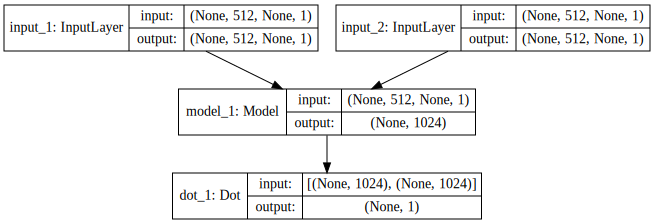

In [33]:
SVG(model_to_dot(siamese,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

#### Preparing the backpropagation

In [26]:
model_input_layer = [siamese.layers[0].input, siamese.layers[1].input]
model_output_layer =  siamese.layers[-1].output

In [27]:
cost_function = model_output_layer[0][0]

In [28]:
gradient_function = K.gradients(cost_function, model_input_layer)[0]

In [29]:
grab_cost_and_gradients_from_model = K.function(model_input_layer, [cost_function, gradient_function])

In [30]:
filter_gradients = lambda c, g, t1, t2: [g[i] for i in range(len(c)) if c[i] >= t1 and c[i] <= t2]

#### Preparing the reconstruction strategy

In [318]:
def stft_for_reconstruction(x, params):
    frames = framesig(x, frame_len=params['frame_len'] * params['sample_rate'], frame_step=params['frame_step'] * params['sample_rate'], winfunc=np.hamming)
    fft_norm = np.fft.fft(frames, n=params['num_fft'])
    return fft_norm

def istft_for_reconstruction(X,total_lenght,  params):
    frames = np.fft.ifft(X, n=params['num_fft'])
    x = deframesig(frames, total_lenght, frame_len=params['num_fft'], frame_step=params['frame_step']*params['sample_rate'], winfunc=np.hamming)
    return x

def reconstruct_signal_griffin_lim(total_lenght, fft, params, iterations=2000):
    x_reconstruct = np.random.randn(total_lenght)
    n = iterations
    while n > 0:
        n -= 1
        reconstruction_spectrogram = stft_for_reconstruction(x_reconstruct, params)
        reconstruction_angle = np.angle(reconstruction_spectrogram)
        proposal_spectrogram = fft * np.exp(1.0j * reconstruction_angle)
        prev_x = x_reconstruct
        x_reconstruct = istft_for_reconstruction(proposal_spectrogram, total_lenght, params)
        diff = np.sqrt(np.sum((fft - abs(proposal_spectrogram))**2)/fft.size)
        print('\rReconstruction iteration: {}/{} RMSE: {} '.format(iterations - n, iterations, diff), end='')
    return x_reconstruct

#### Defining the parameters for creating the adversarial samples

In [28]:
batch_size = 16
n_iterations = 100
learning_rate = 10
min_similarity = 0.25
max_similarity = 0.75
min_change = 1e-5
tau = 0.53

#### Selecting the candidate base master voices

In [59]:
sampled_train_paths_male = []
for rank, (path_id, path, count) in enumerate(ranking_males):
    if (rank % 500) == 0:
        sampled_train_paths_male.append(path)

In [60]:
sampled_train_paths_female = []
for rank, (path_id, path, count) in enumerate(ranking_females):
    if (rank % 500) == 0:
        sampled_train_paths_female.append(path)

#### Generating the adversarial examples

In [ ]:
for i_mv, path in enumerate(sampled_train_paths):
    path = 'mirko.m4a'
    print('\nSample', i_mv+1, '/', len(sampled_train_paths), path)
    sp_mv, mean_mv, std_mv = get_fft_spectrum(path, buckets, params)
    plot_fac = []
    bin_max = 0
    prev_sp = None
    early_stop = 0
    patience = 6
    for batch in range(n_iterations):
        l_costs = []
        l_gradients = []
        indexes = random.sample(males, batch_size)
        for index in indexes:
            sp_nv, _, _ = get_fft_spectrum(train_paths[index], buckets, params)
            input_pair = ([np.array([sp_mv.reshape(*sp_mv.shape, 1)]), np.array([sp_nv.reshape(*sp_nv.shape, 1)])])
            cost, gradients = grab_cost_and_gradients_from_model(input_pair)
            l_costs.append(np.squeeze(cost))
            l_gradients.append(np.squeeze(gradients)) 
        filtered = filter_gradients(l_costs, l_gradients, min_similarity, max_similarity)
        if len(filtered) > 0:
            prev_sp = np.copy(sp_mv)
            perturbation = np.mean(filtered, axis=0) * learning_rate
            perturbation = np.clip(perturbation, min_change, None)
            sp_mv += perturbation 
            base_mv = np.copy(sp_mv)
            emb_mv = contr_model.predict(base_mv.reshape(1, *base_mv.shape, 1))[0]
            mv_similarities = np.zeros(len(train_paths))
            for i in range(len(train_paths)):
                mv_similarities[i] = 1 - spatial.distance.cosine(emb_mv, embs[i])
            bin_sim = np.sum([1 for s in mv_similarities if s > tau])
            if bin_sim > bin_max:
                bin_max = bin_sim
                plot_fac.append(bin_sim)
                early_stop = 0
            else:
                sp_mv = np.copy(prev_sp)
                early_stop += 1
        print('\rStep ' + str(batch+1) + '/' + str(n_iterations), '- FAC', bin_sim, '( MAX', bin_max, ') - EarlyStop', early_stop, end='')
        if early_stop == patience:
            break
        
    signal_sp_mv, rate_sp_mv = librosa.load(path, sr=params['sample_rate'], mono=True)
    total_lenght_mv = len(signal_sp_mv)
    den_sp_mv = denormalize_frames(sp_mv, mean_mv, std_mv)
    x_reconstruct = reconstruct_signal_griffin_lim(total_lenght_mv, den_sp_mv.T, params, iterations=300) 
    
    frames = framesig(x_reconstruct, frame_len=params['frame_len'] * params['sample_rate'], frame_step=params['frame_step']*params['sample_rate'], winfunc=np.hamming)
    fft = abs(np.fft.fft(frames,n=params['num_fft']))
    sp_sc, fft_means, fft_stds = normalize_frames(fft.T)
    base_mv = np.copy(sp_sc)
    
    emb_mv = contr_model.predict(base_mv.reshape(1, *base_mv.shape, 1))[0]
    mv_similarities = np.zeros(len(train_paths))
    for i in range(len(train_paths)):
        mv_similarities[i] = 1 - spatial.distance.cosine(emb_mv, embs[i])
    bin_sim = np.sum([1 for s in mv_similarities if s > tau])
    print('\nFinal FAC', bin_sim, end='')
    
    sf.write('mirko_mv.wav', x_reconstruct, params['sample_rate'])

## Section 6: Test Sampled and Generated Master Voices

In [61]:
def print_results(results, n_thr=2, rank_step=500, rank_pos=[1,7], max_pos=50):
    columns = ['Threshold', 'Rank Pos', 'BaseVSMal', 'MasterVSMal', 'BaseVSFem', 'MasterVSFem']
    for _ in range(n_thr):
        for c in columns:
            print(c, end='\t')
    print('\n-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------')
    for i, r in enumerate(results[:max_pos]):
        for i_c, c in enumerate(r):
            if i_c in rank_pos:
                print(c*rank_step, end='\t\t')
            else:   
                if i_c == len(r):
                    print(c)
                else:
                    print(c, end='\t\t')
        print()
    print('-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------')
    results = np.array(results)
    for i_c, c in enumerate(range(results.shape[1])):
        if i_c in rank_pos:
            print(round(np.mean(results[:max_pos,c]),2)*rank_step, end='\t\t')
        else:
            print(round(np.mean(results[:max_pos,c]),2), end='\t\t')

#### Evaluating people impersonation rate at one-to-any rule 

In [62]:
def eval_any(thresholds, enrol_size, trials, target_paths, target_ordered_labels, target_embs, target_males, target_females, utterance_per_person, folder, sampled_train_paths, n_pairs=50):
    results = []
    for n_thr, thr in enumerate(thresholds):
        #pairs = zip(sampled_train_paths, ['../data/backup/' + folder + '/mv_female_opt_male_' + str(i) + '.wav' for i in range(n_pairs)])
        pairs = zip(sampled_train_paths, ['../data/backup/' + folder + '/mv_' + str(i) + '.wav' for i in range(n_pairs)])
        for n_pair, pair in enumerate(pairs):
            base_l_imp_male = []
            base_l_imp_female = []
            mv_l_imp_male = []
            mv_l_imp_female = []

            base_mv, _, _ = get_fft_spectrum(pair[0], buckets, params)
            sp_mv, _, _ = get_fft_spectrum(pair[1], buckets, params)

            for _ in range(trials):
                emb_base = contr_model.predict(base_mv.reshape(1, *base_mv.shape, 1))[0]
                emb_mv = contr_model.predict(sp_mv.reshape(1, *sp_mv.shape, 1))[0]

                similarities_base = np.zeros(len(target_paths))
                similarities_mv = np.zeros(len(target_paths))
                for i in range(len(target_paths)):
                    similarities_base[i] = 1 - spatial.distance.cosine(emb_base, target_embs[i])
                    similarities_mv[i] = 1 - spatial.distance.cosine(emb_mv, target_embs[i])

                base_false_acceptance_count_per_person = np.zeros(len(target_ordered_labels))
                mv_false_acceptance_count_per_person = np.zeros(len(target_ordered_labels))
                for u_index, u_label in enumerate(target_ordered_labels):
                    indexes = np.array(random.sample(range(utterance_per_person), enrol_size))
                    u_row = np.copy(similarities_base)
                    u_row = u_row[(u_index*utterance_per_person):(u_index*utterance_per_person+utterance_per_person)]
                    u_row = u_row[indexes]
                    fac = len([1 for s in u_row if s > thr])
                    base_false_acceptance_count_per_person[u_index] = fac
                    u_row = np.copy(similarities_mv)
                    u_row = u_row[(u_index*utterance_per_person):(u_index*utterance_per_person+utterance_per_person)]
                    u_row = u_row[indexes]
                    fac = len([1 for s in u_row if s > thr])
                    mv_false_acceptance_count_per_person[u_index] = fac

                imp_males = [index for index, s in enumerate(base_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_males]
                imp_females = [index for index, s in enumerate(base_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_females]
                base_l_imp_male.append(len(imp_males))
                base_l_imp_female.append(len(imp_females))
                imp_males = [index for index, s in enumerate(mv_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_males]
                imp_females = [index for index, s in enumerate(mv_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_females]
                mv_l_imp_male.append(len(imp_males))
                mv_l_imp_female.append(len(imp_females))
            
            item = [thr, 
                    n_pair,
                    round(np.mean(base_l_imp_male) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(mv_l_imp_male) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(base_l_imp_female) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(mv_l_imp_female) / (len(target_ordered_labels) / 2) * 100, 3)
                   ]

            if n_thr == 0:
                results.append(item)
            else:
                results[n_pair] = results[n_pair] + item  
            
            print('\r', 'THR', thr, 'PAIR', n_pair, end='')

    return results

##### One-to-Any10 Males

In [63]:
results_train_any_m = eval_any(thresholds=[0.53, 0.75], 
                             enrol_size = 10, 
                             trials = 1, 
                             target_paths = np.copy(train_paths), 
                             target_ordered_labels = np.copy(ordered_labels), 
                             target_embs = np.copy(embs), 
                             target_males = np.copy(males),
                             target_females = np.copy(females), 
                             utterance_per_person = 50,
                             folder = 'final_mv_male_50',
                             sampled_train_paths = sampled_train_paths_male)

 THR 0.75 PAIR 49

In [64]:
print('Sampled Male Utterances - Training Set - One-to-Any10 Rule\n')
print_results(results_train_any_m)

Sampled Male Utterances - Training Set - One-to-Any10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		81.0		83.4		1.0		1.0		0.75		0		23.0		25.0		0.4		0.4		
0.53		500		73.8		82.2		1.6		2.0		0.75		500		11.2		14.2		0.0		0.0		
0.53		1000		68.8		80.4		1.0		1.6		0.75		1000		8.0		16.6		0.0		0.0		
0.53		1500		72.4		82.8		1.0		1.4		0.75		1500		3.6		14.4		0.4		0.4		
0.53		2000		72.6		77.6		1.6		1.6		0.75		2000		22.2		24.0		0.4		0.4		
0.53		2500		67.6		81.8		2.8		2.8		0.75		2500		10.2		17.0		0.0		0.0		
0.53		3000		65.0		73.4		1.2		1.6		0.75		3000		18.2		21.0		0.4		0.4		
0.53		3500		61.2		72.8		1.4		1.8		0.75		3500		17.0		22.8		0.2		0.0		
0.53		4000		64.4		79.4		1.4		1.8		0.75		4000		9.4		15.8		0.2		0.0		
0.53		4500		54.

In [65]:
results_test_any_m = eval_any(thresholds = [0.53, 0.75], 
                            enrol_size = 10, 
                            trials = 1, 
                            target_paths = np.copy(test_paths), 
                            target_ordered_labels = np.copy(test_ordered_labels), 
                            target_embs = np.copy(test_embs), 
                            target_males = np.copy(test_males),
                            target_females = np.copy(test_females), 
                            utterance_per_person = 100,
                            folder = 'final_mv_male_50',
                            sampled_train_paths = sampled_train_paths_male)

 THR 0.75 PAIR 49

In [66]:
print('Sampled Male Utterances - Test Set - One-to-Any10 Rule\n')
print_results(results_test_any_m)

Sampled Male Utterances - Test Set - One-to-Any10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		76.6		79.6		3.2		3.4		0.75		0		22.8		24.0		0.2		0.6		
0.53		500		71.6		80.6		1.8		2.2		0.75		500		11.0		13.2		0.2		0.4		
0.53		1000		64.8		77.6		1.6		2.0		0.75		1000		7.4		15.8		0.2		0.4		
0.53		1500		72.0		79.2		1.8		2.4		0.75		1500		4.4		12.6		0.0		0.2		
0.53		2000		66.4		69.4		1.6		1.8		0.75		2000		19.6		21.8		0.0		0.0		
0.53		2500		64.2		78.8		3.4		2.2		0.75		2500		9.0		16.2		0.0		0.4		
0.53		3000		62.6		73.4		1.6		2.4		0.75		3000		13.6		17.4		0.2		0.2		
0.53		3500		62.2		73.2		1.6		2.4		0.75		3500		15.6		22.8		0.0		0.2		
0.53		4000		63.8		78.0		1.6		1.4		0.75		4000		8.2		16.6		0.0		0.0		
0.53		4500		47.8		72

##### One-to-Any10 Females

In [67]:
results_train_any_f = eval_any(thresholds=[0.53, 0.75], 
                             enrol_size = 10, 
                             trials = 1, 
                             target_paths = np.copy(train_paths), 
                             target_ordered_labels = np.copy(ordered_labels), 
                             target_embs = np.copy(embs), 
                             target_males = np.copy(males),
                             target_females = np.copy(females), 
                             utterance_per_person = 50,
                             folder = 'final_mv_female_50',
                             sampled_train_paths = sampled_train_paths_female)

 THR 0.75 PAIR 49

In [68]:
print('Sampled Female Utterances - Training Set - One-to-Any10 Rule\n')
print_results(results_train_any_f)

Sampled Female Utterances - Training Set - One-to-Any10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		1.6		1.6		94.4		96.8		0.75		0		0.2		0.6		31.2		43.4		
0.53		500		2.2		2.4		89.4		93.4		0.75		500		0.4		0.4		17.6		31.2		
0.53		1000		1.8		1.8		90.8		93.0		0.75		1000		0.8		0.6		31.0		37.4		
0.53		1500		3.0		3.0		88.6		90.6		0.75		1500		0.2		0.2		28.0		30.8		
0.53		2000		2.6		3.2		91.6		95.0		0.75		2000		0.2		0.2		33.2		42.8		
0.53		2500		1.4		1.6		79.2		89.4		0.75		2500		0.0		0.2		7.4		21.4		
0.53		3000		1.6		2.4		84.8		91.0		0.75		3000		0.2		0.2		22.4		30.8		
0.53		3500		1.4		1.6		86.0		92.0		0.75		3500		0.0		0.2		21.0		35.6		
0.53		4000		1.6		1.8		77.0		89.8		0.75		4000		0.2		0.2		16.2		30.2		
0.53		4500	

In [69]:
results_test_any_f = eval_any(thresholds = [0.53, 0.75], 
                            enrol_size = 10, 
                            trials = 1, 
                            target_paths = np.copy(test_paths), 
                            target_ordered_labels = np.copy(test_ordered_labels), 
                            target_embs = np.copy(test_embs), 
                            target_males = np.copy(test_males),
                            target_females = np.copy(test_females), 
                            utterance_per_person = 100,
                            folder = 'final_mv_female_50',
                            sampled_train_paths = sampled_train_paths_female)

 THR 0.75 PAIR 49

In [70]:
print('Sampled Female Utterances - Test Set - One-to-Any10 Rule\n')
print_results(results_test_any_f)

Sampled Female Utterances - Test Set - One-to-Any10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		1.6		1.6		90.4		92.6		0.75		0		0.0		0.0		35.0		41.4		
0.53		500		2.0		2.2		83.6		88.0		0.75		500		0.0		0.2		13.6		23.6		
0.53		1000		1.2		1.4		87.8		90.6		0.75		1000		0.4		0.6		24.4		32.0		
0.53		1500		1.4		1.6		87.8		89.2		0.75		1500		0.2		0.2		24.2		29.0		
0.53		2000		1.2		1.2		89.6		93.2		0.75		2000		0.2		0.2		31.2		39.2		
0.53		2500		1.2		1.6		77.0		87.6		0.75		2500		0.0		0.0		9.0		20.6		
0.53		3000		0.6		1.2		80.2		85.8		0.75		3000		0.0		0.2		21.6		31.2		
0.53		3500		0.6		0.8		80.2		88.0		0.75		3500		0.0		0.0		26.6		36.8		
0.53		4000		1.8		1.8		74.0		87.8		0.75		4000		0.0		0.0		13.0		26.6		
0.53		4500		1.0

#### Evaluating people impersonation rate at one-to-avg rule 

In [71]:
def eval_avg(thresholds, enrol_size, trials, target_paths, target_ordered_labels, target_embs, target_males, target_females, utterance_per_person, folder, sampled_train_paths, n_pairs=50):
    results = []
    for n_thr, thr in enumerate(thresholds):
        #pairs = zip(sampled_train_paths, ['../data/backup/' + folder + '/mv_female_opt_male_' + str(i) + '.wav' for i in range(n_pairs)])
        pairs = zip(sampled_train_paths, ['../data/backup/' + folder + '/mv_' + str(i) + '.wav' for i in range(n_pairs)])
        for n_pair, pair in enumerate(pairs):
            base_l_imp_male = []
            base_l_imp_female = []
            mv_l_imp_male = []
            mv_l_imp_female = []

            base_mv, _, _ = get_fft_spectrum(pair[0], buckets, params)
            sp_mv, _, _ = get_fft_spectrum(pair[1], buckets, params)

            for _ in range(trials):
                emb_base = contr_model.predict(base_mv.reshape(1, *base_mv.shape, 1))[0]
                emb_mv = contr_model.predict(sp_mv.reshape(1, *sp_mv.shape, 1))[0]

                base_false_acceptance_count_per_person = np.zeros(len(target_ordered_labels))
                mv_false_acceptance_count_per_person = np.zeros(len(target_ordered_labels))
                for u_index, u_label in enumerate(target_ordered_labels):
                    indexes = np.array(random.sample(range(utterance_per_person), enrol_size))
                    u_embs = target_embs[(u_index*utterance_per_person):(u_index*utterance_per_person+utterance_per_person)]
                    u_embs = np.mean(u_embs[indexes], axis=0)

                    s = 1 - spatial.distance.cosine(emb_base, u_embs)
                    base_false_acceptance_count_per_person[u_index] = (1 if s > thr else 0)

                    s = 1 - spatial.distance.cosine(emb_mv, u_embs)
                    mv_false_acceptance_count_per_person[u_index] = (1 if s > thr else 0)

                imp_males = [index for index, s in enumerate(base_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_males]
                imp_females = [index for index, s in enumerate(base_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_females]
                base_l_imp_male.append(len(imp_males))
                base_l_imp_female.append(len(imp_females))
                imp_males = [index for index, s in enumerate(mv_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_males]
                imp_females = [index for index, s in enumerate(mv_false_acceptance_count_per_person) if s >= 1 and index*utterance_per_person in target_females]
                mv_l_imp_male.append(len(imp_males))
                mv_l_imp_female.append(len(imp_females))
            
            item = [thr, 
                    n_pair,
                    round(np.mean(base_l_imp_male) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(mv_l_imp_male) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(base_l_imp_female) / (len(target_ordered_labels) / 2) * 100, 3),
                    round(np.mean(mv_l_imp_female) / (len(target_ordered_labels) / 2) * 100, 3)
                   ]

            if n_thr == 0:
                results.append(item)
            else:
                results[n_pair] = results[n_pair] + item  
            
            print('\r', 'THR', thr, 'PAIR', n_pair, end='')

    return results

##### One-to-AVG10 Male

In [72]:
results_train_avg_m = eval_avg(thresholds=[0.53, 0.75], 
                             enrol_size = 10, 
                             trials = 1, 
                             target_paths = np.copy(train_paths), 
                             target_ordered_labels = np.copy(ordered_labels), 
                             target_embs = np.copy(embs), 
                             target_males = np.copy(males),
                             target_females = np.copy(females), 
                             utterance_per_person = 50,
                             folder = 'final_mv_male_50',
                             sampled_train_paths = sampled_train_paths_male)

 THR 0.75 PAIR 49

In [73]:
print('Sampled Male Utterances - Training Set - One-to-Avg10 Rule\n')
print_results(results_train_avg_m)

Sampled Male Utterances - Training Set - One-to-Avg10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		60.2		63.4		0.0		0.0		0.75		0		13.8		15.8		0.0		0.0		
0.53		500		52.2		62.4		0.0		0.0		0.75		500		6.0		8.2		0.0		0.0		
0.53		1000		43.2		57.6		0.2		0.4		0.75		1000		2.8		7.6		0.0		0.0		
0.53		1500		50.4		64.6		0.2		0.2		0.75		1500		1.8		8.0		0.0		0.0		
0.53		2000		45.2		50.4		0.0		0.0		0.75		2000		10.2		11.6		0.0		0.0		
0.53		2500		46.2		61.4		0.2		0.2		0.75		2500		3.4		8.4		0.0		0.0		
0.53		3000		43.6		53.4		0.2		0.4		0.75		3000		6.4		9.8		0.0		0.0		
0.53		3500		37.6		52.6		0.4		0.4		0.75		3500		7.0		13.2		0.0		0.0		
0.53		4000		38.4		56.2		0.2		0.4		0.75		4000		3.0		9.0		0.0		0.0		
0.53		4500		25.2		51.4		0

In [74]:
results_test_avg_m = eval_avg(thresholds = [0.53, 0.75], 
                            enrol_size = 10, 
                            trials = 1, 
                            target_paths = np.copy(test_paths), 
                            target_ordered_labels = np.copy(test_ordered_labels), 
                            target_embs = np.copy(test_embs), 
                            target_males = np.copy(test_males),
                            target_females = np.copy(test_females), 
                            utterance_per_person = 100,
                            folder = 'final_mv_male_50',
                            sampled_train_paths = sampled_train_paths_male)

 THR 0.75 PAIR 49

In [75]:
print('Sampled Male Utterances - Test Set - One-to-Avg10 Rule\n')
print_results(results_test_avg_m)

Sampled Male Utterances - Test Set - One-to-Avg10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		56.8		60.4		0.4		0.4		0.75		0		11.4		12.4		0.0		0.0		
0.53		500		48.8		60.8		0.4		0.6		0.75		500		3.8		6.4		0.2		0.2		
0.53		1000		39.0		55.2		0.2		0.2		0.75		1000		2.2		7.6		0.0		0.0		
0.53		1500		50.4		61.6		0.2		0.2		0.75		1500		2.6		6.8		0.0		0.0		
0.53		2000		42.6		47.8		0.2		0.2		0.75		2000		8.4		10.0		0.0		0.0		
0.53		2500		42.6		56.0		1.2		0.6		0.75		2500		3.6		9.6		0.0		0.0		
0.53		3000		42.4		52.6		0.0		0.0		0.75		3000		5.2		7.8		0.0		0.0		
0.53		3500		37.8		51.0		0.2		0.2		0.75		3500		6.4		11.2		0.0		0.0		
0.53		4000		38.8		53.4		0.2		0.6		0.75		4000		3.4		9.4		0.0		0.0		
0.53		4500		21.6		42.8		0.0		0

##### One-to-AVG10 Female

In [76]:
results_train_avg_f = eval_avg(thresholds=[0.53, 0.75], 
                             enrol_size = 10, 
                             trials = 1, 
                             target_paths = np.copy(train_paths), 
                             target_ordered_labels = np.copy(ordered_labels), 
                             target_embs = np.copy(embs), 
                             target_males = np.copy(males),
                             target_females = np.copy(females), 
                             utterance_per_person = 50,
                             folder = 'final_mv_female_50',
                             sampled_train_paths = sampled_train_paths_female)

 THR 0.75 PAIR 49

In [77]:
print('Sampled Female Utterances - Training Set - One-to-Avg10 Rule\n')
print_results(results_train_avg_f)

Sampled Female Utterances - Training Set - One-to-Avg10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		0.4		0.6		77.8		84.6		0.75		0		0.2		0.2		19.0		28.4		
0.53		500		0.6		0.8		69.2		79.4		0.75		500		0.2		0.4		8.2		18.0		
0.53		1000		0.6		0.6		75.0		80.2		0.75		1000		0.0		0.0		16.8		23.0		
0.53		1500		0.8		0.8		73.8		77.4		0.75		1500		0.0		0.0		16.8		19.6		
0.53		2000		0.6		0.6		77.2		84.6		0.75		2000		0.0		0.0		21.6		30.0		
0.53		2500		0.6		0.6		49.4		71.4		0.75		2500		0.0		0.0		2.8		9.2		
0.53		3000		0.4		0.6		61.6		73.6		0.75		3000		0.0		0.0		9.0		17.0		
0.53		3500		0.6		0.6		62.8		75.2		0.75		3500		0.0		0.0		11.0		20.8		
0.53		4000		0.2		0.8		49.2		70.4		0.75		4000		0.0		0.2		5.6		15.4		
0.53		4500		0.4

In [78]:
results_test_avg_f = eval_avg(thresholds = [0.53, 0.75], 
                            enrol_size = 10, 
                            trials = 1, 
                            target_paths = np.copy(test_paths), 
                            target_ordered_labels = np.copy(test_ordered_labels), 
                            target_embs = np.copy(test_embs), 
                            target_males = np.copy(test_males),
                            target_females = np.copy(test_females), 
                            utterance_per_person = 100,
                            folder = 'final_mv_female_50',
                            sampled_train_paths = sampled_train_paths_female)

 THR 0.75 PAIR 49

In [79]:
print('Sampled Female Utterances - Test Set - One-to-Avg10 Rule\n')
print_results(results_test_avg_f)

Sampled Female Utterances - Test Set - One-to-Avg10 Rule

Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	Threshold	Rank Pos	BaseVSMal	MasterVSMal	BaseVSFem	MasterVSFem	
-------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------
0.53		0		0.6		0.6		77.6		82.0		0.75		0		0.0		0.0		18.8		28.2		
0.53		500		0.2		0.2		63.6		72.6		0.75		500		0.0		0.0		5.6		13.4		
0.53		1000		0.4		0.4		66.4		74.0		0.75		1000		0.0		0.2		13.4		20.2		
0.53		1500		0.6		0.8		67.8		73.8		0.75		1500		0.2		0.2		13.8		17.4		
0.53		2000		0.8		0.6		75.6		84.0		0.75		2000		0.0		0.0		20.4		28.4		
0.53		2500		0.2		0.2		48.6		68.2		0.75		2500		0.0		0.0		3.4		13.2		
0.53		3000		0.2		0.2		56.8		71.4		0.75		3000		0.0		0.0		10.0		16.0		
0.53		3500		0.0		0.2		62.4		74.4		0.75		3500		0.0		0.0		14.0		24.6		
0.53		4000		0.2		0.4		43.0		66.0		0.75		4000		0.0		0.0		5.6		13.2		
0.53		4500		0.4		

## Section 7: Do the generated "Master Voices" generalize well to other speaker verification systems?

In [253]:
np.save('results_train_any_m.npy', results_train_any_m)
np.save('results_test_any_m.npy', results_test_any_m)
np.save('results_train_any_f.npy', results_train_any_f)
np.save('results_test_any_f.npy', results_test_any_f)
np.save('results_train_avg_m.npy', results_train_avg_m)
np.save('results_test_avg_m.npy', results_test_avg_m)
np.save('results_train_avg_f.npy', results_train_avg_f)
np.save('results_test_avg_f.npy', results_test_avg_f)

## Section 8: Are the generated "Master Voices" statistically better than the existing "Master Voices"?  

In [ ]:
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [254]:
results_train_any_m = np.load('results_train_any_m')
results_test_any_m = np.load('results_test_any_m')
results_train_any_f = np.load('results_train_any_f')
results_test_any_f = np.load('results_test_any_f')
results_train_avg_m = np.load('results_train_avg_m')
results_test_avg_m = np.load('results_test_avg_m')
results_train_avg_f = np.load('results_train_avg_f')
results_test_avg_f = np.load('results_test_avg_f')

FileNotFoundError: [Errno 2] No such file or directory: 'results_train_any_m'

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label tex

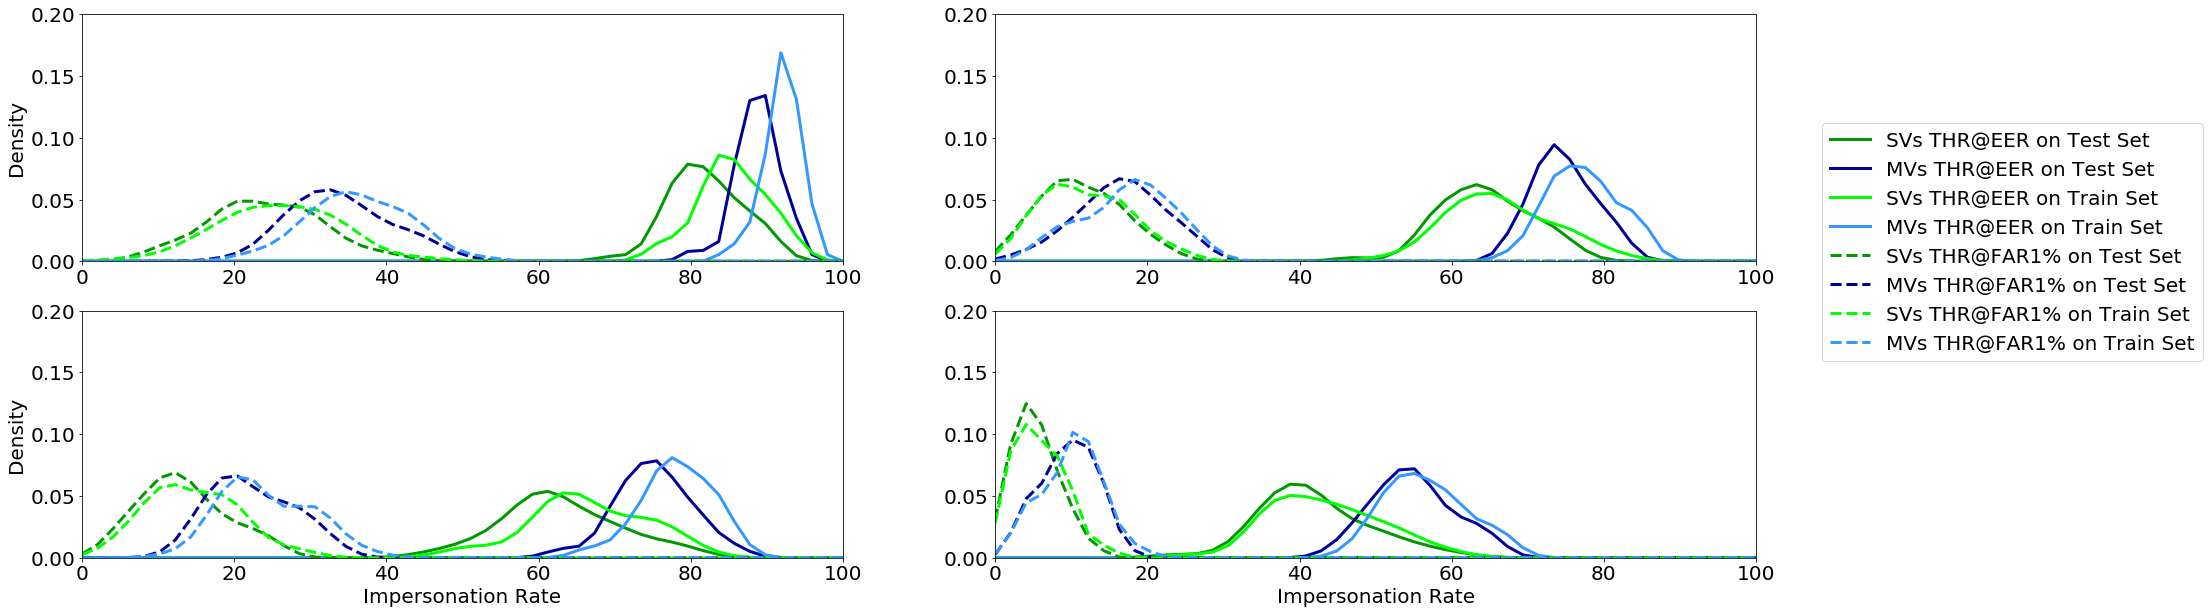

In [103]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(30, 10))

top_n_utterances = 25
top_line_width = 3
top_y_lim = 0.20

top_index_target_eer_f_sv = 4
top_index_target_eer_f_mv = 5
top_index_target_far1_f_sv = 10
top_index_target_far1_f_mv = 11

top_index_target_eer_m_sv = 2
top_index_target_eer_m_mv = 3
top_index_target_far1_m_sv = 8
top_index_target_far1_m_mv = 9

# ********** DISTRIBUTION FOR ANY10 UNDER F-F-F ****************
plt.subplot(221)
plt.ylabel('Density')

distrib = np.array(results_test_any_f)[:top_n_utterances,top_index_target_eer_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Test Set', color=(0,0.6,0))
distrib = np.array(results_test_any_f)[:top_n_utterances,top_index_target_eer_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Test Set', color=(0,0,0.6))
distrib = np.array(results_train_any_f)[:top_n_utterances,top_index_target_eer_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Train Set', color=(0,1,0))
distrib = np.array(results_train_any_f)[:top_n_utterances,top_index_target_eer_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Train Set', color=(0.2,0.6,1.0))

distrib = np.array(results_test_any_f)[:top_n_utterances,top_index_target_far1_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Test Set', linestyle='--', color=(0,0.6,0))
distrib = np.array(results_test_any_f)[:top_n_utterances,top_index_target_far1_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Test Set', linestyle='--', color=(0,0,0.6))
distrib = np.array(results_train_any_f)[:top_n_utterances,top_index_target_far1_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Train Set', linestyle='--', color=(0,1,0))
distrib = np.array(results_train_any_f)[:top_n_utterances,top_index_target_far1_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Train Set', linestyle='--', color=(0.2,0.6,1.0))

plt.xlim([0, 100.0])
plt.ylim([0, top_y_lim])

# ********** DISTRIBUTION FOR ANY10 UNDER M-M-M ****************
plt.subplot(222)

distrib = np.array(results_test_any_m)[:top_n_utterances,top_index_target_eer_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Test Set', color=(0,0.6,0))
distrib = np.array(results_test_any_m)[:top_n_utterances,top_index_target_eer_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Test Set', color=(0,0,0.6))
distrib = np.array(results_train_any_m)[:top_n_utterances,top_index_target_eer_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Train Set', color=(0,1,0))
distrib = np.array(results_train_any_m)[:top_n_utterances,top_index_target_eer_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Train Set', color=(0.2,0.6,1.0))


distrib = np.array(results_test_any_m)[:top_n_utterances,top_index_target_far1_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Test Set', linestyle='--', color=(0,0.6,0))
distrib = np.array(results_test_any_m)[:top_n_utterances,top_index_target_far1_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Test Set', linestyle='--', color=(0,0,0.6))
distrib = np.array(results_train_any_m)[:top_n_utterances,top_index_target_far1_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='EVs on Train Set', linestyle='--', color=(0,1,0))
distrib = np.array(results_train_any_m)[:top_n_utterances,top_index_target_far1_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs on Train Set', linestyle='--', color=(0.2,0.6,1.0))

plt.xlim([0, 100.0])
plt.ylim([0, top_y_lim])

# ********** DISTRIBUTION FOR AVG10 UNDER F-F-F ****************
plt.subplot(223)
plt.xlabel('Impersonation Rate')
plt.ylabel('Density')

distrib = np.array(results_test_avg_f)[:top_n_utterances,top_index_target_eer_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Test BaseVoice @ EER', color=(0,0.6,0))
distrib = np.array(results_test_avg_f)[:top_n_utterances,top_index_target_eer_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Test MasterVoice @ EER', color=(0,0,0.6))
distrib = np.array(results_train_avg_f)[:top_n_utterances,top_index_target_eer_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Train BaseVoice @ EER', color=(0,1,0))
distrib = np.array(results_train_avg_f)[:top_n_utterances,top_index_target_eer_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Train MasterVoice @ EER', color=(0.2,0.6,1.0))

distrib = np.array(results_test_avg_f)[:top_n_utterances,top_index_target_far1_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Test BaseVoice @ FAR1%', linestyle='--', color=(0,0.6,0))
distrib = np.array(results_test_avg_f)[:top_n_utterances,top_index_target_far1_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Test MasterVoice @ FAR1%', linestyle='--', color=(0,0,0.6))
distrib = np.array(results_train_avg_f)[:top_n_utterances,top_index_target_far1_f_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Train BaseVoice @ FAR1%', linestyle='--', color=(0,1,0))
distrib = np.array(results_train_avg_f)[:top_n_utterances,top_index_target_far1_f_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='Train MasterVoice @ FAR1%', linestyle='--', color=(0.2,0.6,1.0))
plt.xlim([0, 100.0])
plt.ylim([0, top_y_lim])

# ********** DISTRIBUTION FOR AVG10 UNDER M-M-M ****************
plt.subplot(224)
plt.xlabel('Impersonation Rate')

distrib = np.array(results_test_avg_m)[:top_n_utterances,top_index_target_eer_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='SVs THR@EER on Test Set', color=(0,0.6,0))
distrib = np.array(results_test_avg_m)[:top_n_utterances,top_index_target_eer_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs THR@EER on Test Set', color=(0,0,0.6))
distrib = np.array(results_train_avg_m)[:top_n_utterances,top_index_target_eer_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='SVs THR@EER on Train Set', color=(0,1,0))
distrib = np.array(results_train_avg_m)[:top_n_utterances,top_index_target_eer_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs THR@EER on Train Set', color=(0.2,0.6,1.0))

distrib = np.array(results_test_avg_m)[:top_n_utterances,top_index_target_far1_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='SVs THR@FAR1% on Test Set', linestyle='--', color=(0,0.6,0))
distrib = np.array(results_test_avg_m)[:top_n_utterances,top_index_target_far1_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs THR@FAR1% on Test Set', linestyle='--', color=(0,0,0.6))
distrib = np.array(results_train_avg_m)[:top_n_utterances,top_index_target_far1_m_sv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='SVs THR@FAR1% on Train Set', linestyle='--', color=(0,1,0))
distrib = np.array(results_train_avg_m)[:top_n_utterances,top_index_target_far1_m_mv]
density = stats.gaussian_kde(distrib)
n, x, _ = plt.hist(distrib, bins=np.linspace(0, 100.0), histtype=u'step', density=True, alpha = 0.0)  
plt.plot(x, density(x), lw=top_line_width, label='MVs THR@FAR1% on Train Set', linestyle='--', color=(0.2,0.6,1.0))
plt.xlim([0, 100.0])
plt.ylim([0, top_y_lim])

plt.legend(loc='upper right', bbox_to_anchor=(1.60, +1.80))

plt.savefig("results.pdf", bbox_inches='tight')

tikz_save("results.tex")

plt.show()